# Projet 9: [Prédisez la demande en électricité](#M0)

# Table des matières  <a id="sommaire" name="sommaire"></a>
           
**[Mission 0](#M0)**
- [Découverte des données](#M01)
    - [1. Données mensuelles de consommation d'électricité](#M011)
    - [2. Données mensuelles de la température due au chauffage électrique](#M012)

**[Mission 1](#M1)**
- [1. Correction des données de consommation mensuelles de l'effet température par régression linéaire](#M11)
    - [a) Régression linéaire sur la série temporelle](#M111)
    - [b) Correction de l'effet température sur la consommation](#M112)
- [2. Décomposition de la consommation corrigée](#M12)

**[Mission 2](#M2)**
- [Désaisonnalisation de la consommation corrigée grâce aux moyennes mobiles](#M21)

**[Mission 3](#M3)**
- [Prévision de la consommation corrigée sur un an](#M31)
    - [1. Méthode de Holt Winters](#M311)
        - [a) Modèle de Holt-Winters additif avec erreurs additives](#M31)
        - [b) Modèle de Holt-Winters additif avec erreurs multiplicatives](#M32)
    - [2. Méthode SARIMA](#M312)
        - [a) Détermination du modèle](#M3121)
        - [b) Validation du modèle](#M3122)
        - [c) Prédiction de la consommation corrigée](#M3123)
            - [Analyse a posteriori](#M31231)
    
**[Mission 4](#M4)**
- [Prévision de la consommation initiale sur un an](#M41)

In [1]:
library(tibble)
library(dplyr) 
library(tidyr)
library(repr)
library(openxlsx) 
library(reshape2) # Commandes dcast, melt
library(lubridate) # Formatage de dates
library(ggplot2)
library(ggfortify) # autoplot (marche de paire avec ggplot2)
library(car) # Test de Durbin-Watson 
library(normtest) # Test de Jarque-Bera
library(forecast) # Prédiction méthode Holt-Winters, etc
library(tseries) # Test de stationnarité Dickey-Fuller
library(caschrono) # contient la commande Box.test.2
library(latex2exp) # formules Latex

Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'openxlsx' was built under R version 3.6.3"Warning message:
"package 'reshape2' was built under R version 3.6.3"
Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Warning message:
"package 'lubridate' was built under R version 3.6.3"
Attaching package: 'lubridate'

The following objects are masked from 'package:base':

    date, intersect, setdiff, union

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'ggfortify' was built under R version 3.6.3"Warning message:
"package 'car' wa

In [2]:
options(repr.matrix.max.rows = 10, repr.matrix.max.cols = 18)

<a href="#sommaire">Retour au sommaire</a>
# Mission 0.<a name="M0"></a>
# <span style='color:red'>Découverte des données.<a name="M01"></a>
## <span style='color:blue'>1. Données mensuelles de consommation d'électricité.<a name="M011"></a>

In [3]:
conso <- read.xlsx('Fichiers/Conso.xlsx', sep.names = " ")
dim(conso)
conso

[1] 1143   22

Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges aves la Suisse,Echanges avec l'Allemagne et la Belgique
0000-00,Données consolidées,Grand-Est,11346,8643,1120,22,2,1095,...,4545,6711,NA,NA,NA,NA,NA,NA,NA
0000-00,Données consolidées,Nouvelle-Aquitaine,5289,4179,164,NA,0,164,...,4578,711,NA,NA,NA,NA,NA,NA,NA
0000-00,Données consolidées,Auvergne-Rhône-Alpes,11622,8382,334,6,11,316,...,6834,4483,NA,NA,NA,NA,NA,NA,NA
0000-00,Données consolidées,Bourgogne-Franche-Comté,467,NA,124,NA,0,123,...,2188,-1724,NA,NA,NA,NA,NA,NA,NA
0000-00,Données consolidées,Bretagne,535,NA,182,NA,4,178,...,2443,-1915,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,,...,...,...,...,...,...,...,...,...
2020-02,Données consolidées,Occitanie,3243,1583,63,NA,0,63,...,3336,-269,NA,NA,NA,NA,NA,NA,NA
2020-02,Données consolidées,Normandie,4739,4074,284,-5,29,260,...,2619,2120,NA,NA,NA,NA,NA,NA,NA
2020-02,Données consolidées,Hauts-de-France,5572,2852,815,0,5,809,...,4578,994,NA,NA,NA,NA,NA,NA,NA
2020-02,Données consolidées,PACA,2039,NA,591,0,14,577,...,3598,-1565,NA,NA,NA,NA,NA,NA,NA


In [4]:
summary(conso)

     Mois             Qualité           Territoire        Production totale
 Length:1143        Length:1143        Length:1143        Min.   :   63.0  
 Class :character   Class :character   Class :character   1st Qu.:  561.5  
 Mode  :character   Mode  :character   Mode  :character   Median : 3669.0  
                                                          Mean   : 7354.3  
                                                          3rd Qu.: 7313.5  
                                                          Max.   :58310.0  
                                                                           
 Production nucléaire Production thermique totale Production thermique charbon
 Min.   :  618        Min.   :  -3.0              Min.   : -10                
 1st Qu.: 3191        1st Qu.:  34.0              1st Qu.:   0                
 Median : 5381        Median : 177.0              Median :  23                
 Mean   : 8707        Mean   : 557.4              Mean   : 183              

L'étude portera sur la Nouvelle-Aquitaine et sera restreinte du 1er janvier 2014 au 31 décembre 2018, pour avoir une périodicité entière lors de l'analyse en série temporelle.

In [5]:
(conso <- conso %>% filter(conso$Territoire == 'Nouvelle-Aquitaine', 2014 < conso$Mois, conso$Mois < 2019) %>% 
 select(Mois, 'Consommation totale'))

Mois,Consommation totale
2014-01,4501
2014-02,4184
2014-03,3993
2014-04,3237
2014-05,3100
...,...
2018-08,3135
2018-09,2953
2018-10,3315
2018-11,4024


In [6]:
# Données manquantes: 
sapply(conso, function(x) sum(is.na(x)))

Mois Consommation totale 
                  0                   0

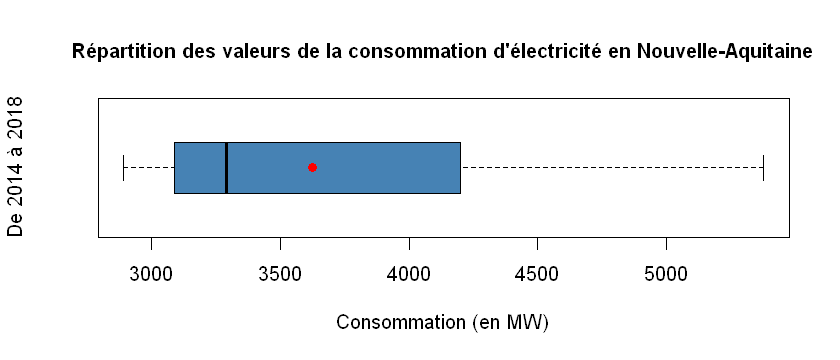

In [7]:
options(repr.plot.width = 7, repr.plot.height = 3)
boxplot(conso[, 2], xlab = 'Consommation (en MW)', ylab = 'De 2014 à 2018', col = 'steelblue', horizontal = T, cex.main = 1,
        main = 'Répartition des valeurs de la consommation d\'électricité en Nouvelle-Aquitaine')
points(mean(conso[, 2]), y = 1, pch = 21, col = 'red', bg = 'red')

In [8]:
# Transformation en série temporelle:
conso_ts <- ts(conso[, 2], start = c(2014, 01), end = c(2018, 12), freq = 12)

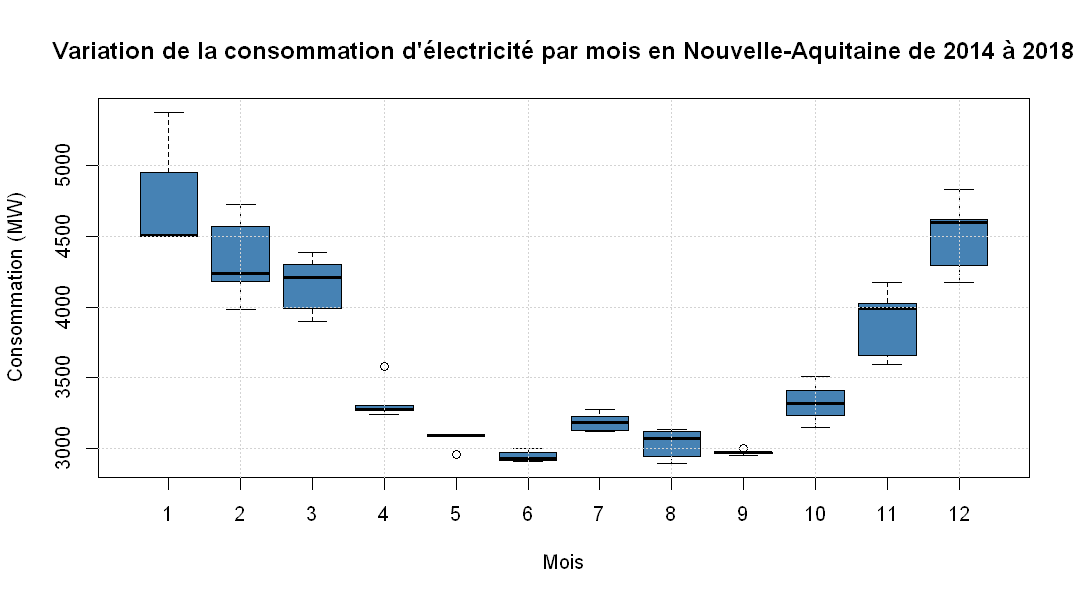

In [9]:
options(repr.plot.width = 9, repr.plot.height = 5)
boxplot(conso_ts ~ cycle(conso_ts), xlab = 'Mois', ylab = 'Consommation (MW)', col = 'steelblue', 
        main = 'Variation de la consommation d\'électricité par mois en Nouvelle-Aquitaine de 2014 à 2018')
grid()

CCL: Les variations les plus fortes se situent de novembre à mars, période de froid plus ou moins prononcée selon les années.

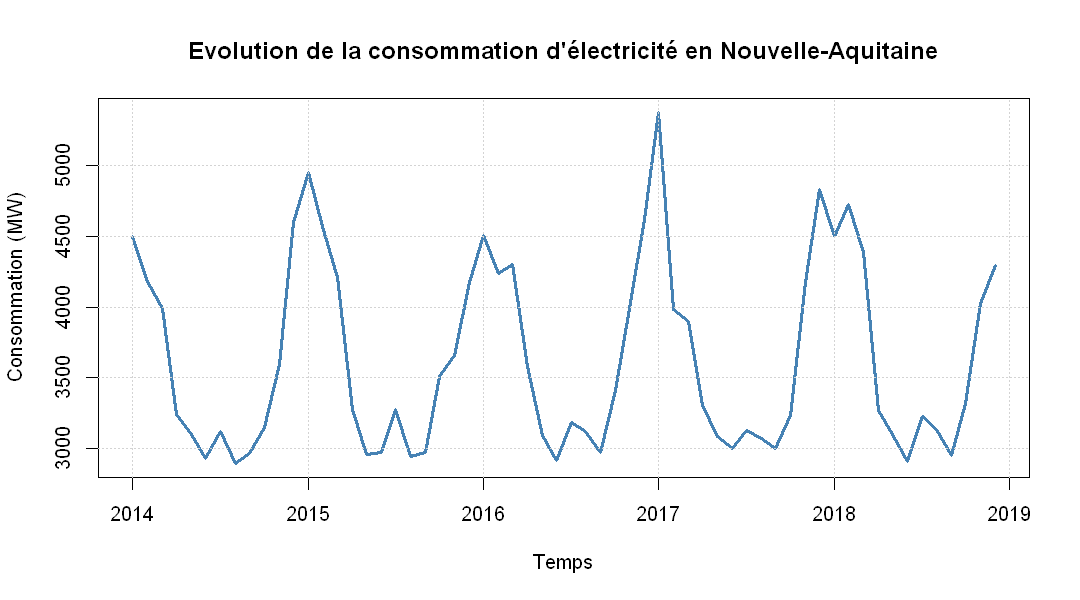

In [10]:
options(repr.plot.width = 9, repr.plot.height = 5)
plot(conso_ts, xlab = 'Temps', ylab = 'Consommation (MW)', col = 'steelblue', lw = 3, 
     main = 'Evolution de la consommation d\'électricité en Nouvelle-Aquitaine')
grid()

CCL: Tendance stable, saisonnalité de période 12 marquée logiquement par une période de froid et une période de chaud.

<a href="#sommaire">Retour au sommaire</a>
## <span style='color:blue'>2. Données mensuelles de la température due au chauffage électrique.<a name="M012"></a>

Le degré jour unifié (DJU) est la différence entre la température extérieure et une température de référence.

Ici, les données de calculs s'appuient sur les considérations suivantes:
- Station météo basée à Toulouse.
- Méthode "Météo".
- Type d'usage "Chauffage".
- Seuil de température établie à 18°C.
- du 01 janvier 2014 au 31 décembre 2018

In [11]:
dju <- read.xlsx('Fichiers/DJU.xlsx', startRow = 11)
(dju <- dju %>% filter(2014 <= dju$X1) %>% select(-Total) %>% arrange(X1))

X1,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC
2014,290.3,271.7,227.2,109.7,82.1,1.9,0.9,0.8,6.7,38.7,146.6,363.0
2015,375.2,349.1,227.8,111.1,42.9,1.0,1.3,0.3,23.7,109.7,187.5,234.5
2016,288.2,277.0,259.3,151.6,77.0,9.5,1.6,0.0,4.5,92.9,216.2,334.8
2017,436.6,238.5,202.3,143.4,47.5,5.8,1.3,2.2,30.7,64.3,284.3,361.8
2018,275.7,363.1,261.2,112.1,76.1,1.9,0.0,0.0,2.9,103.7,210.7,265.4


In [12]:
# Création d'un index en format "année-mois":
(index <- substr(parse_date_time(paste(dju$X1, col(dju[, 1:12])),"%Y-%m"), 0, 7))
#(index <- format(as.Date(parse_date_time(paste(dju$X1, col(dju[, 1:12])), "%Y-%m")), "%Y-%m"))

[1] "2014-01" "2015-01" "2016-01" "2017-01" "2018-01" "2014-02" "2015-02"
 [8] "2016-02" "2017-02" "2018-02" "2014-03" "2015-03" "2016-03" "2017-03"
[15] "2018-03" "2014-04" "2015-04" "2016-04" "2017-04" "2018-04" "2014-05"
[22] "2015-05" "2016-05" "2017-05" "2018-05" "2014-06" "2015-06" "2016-06"
[29] "2017-06" "2018-06" "2014-07" "2015-07" "2016-07" "2017-07" "2018-07"
[36] "2014-08" "2015-08" "2016-08" "2017-08" "2018-08" "2014-09" "2015-09"
[43] "2016-09" "2017-09" "2018-09" "2014-10" "2015-10" "2016-10" "2017-10"
[50] "2018-10" "2014-11" "2015-11" "2016-11" "2017-11" "2018-11" "2014-12"
[57] "2015-12" "2016-12" "2017-12" "2018-12"

In [13]:
# Défusionnement des mois et des années:
dju <- cbind(index, dju %>% melt(id.vars = 'X1')) %>% select(c(index, value)) %>% rename(Mois = index, DJU = value) %>% arrange(Mois)
dju

Mois,DJU
2014-01,290.3
2014-02,271.7
2014-03,227.2
2014-04,109.7
2014-05,82.1
...,...
2018-08,0.0
2018-09,2.9
2018-10,103.7
2018-11,210.7


In [14]:
# Données manquantes:
sapply(dju, function(x) sum(is.na(x)))

Mois  DJU 
   0    0

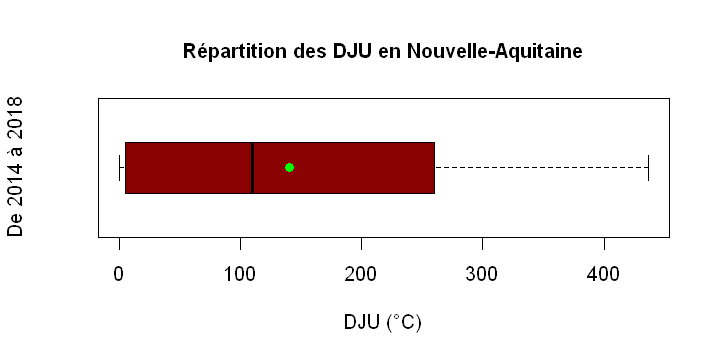

In [15]:
options(repr.plot.width = 6, repr.plot.height = 3)
boxplot(dju[, 2], xlab = 'DJU (°C)', ylab = 'De 2014 à 2018', col = 'darkred', horizontal = T, cex.main = 1,
        main = 'Répartition des DJU en Nouvelle-Aquitaine')
points(mean(dju[, 2]), y = 1, pch = 21, col = 'green', bg = 'green')

In [16]:
# Conversion en série temporelle 
dju_ts <- ts(dju[, 2], start = 2014, freq = 12)

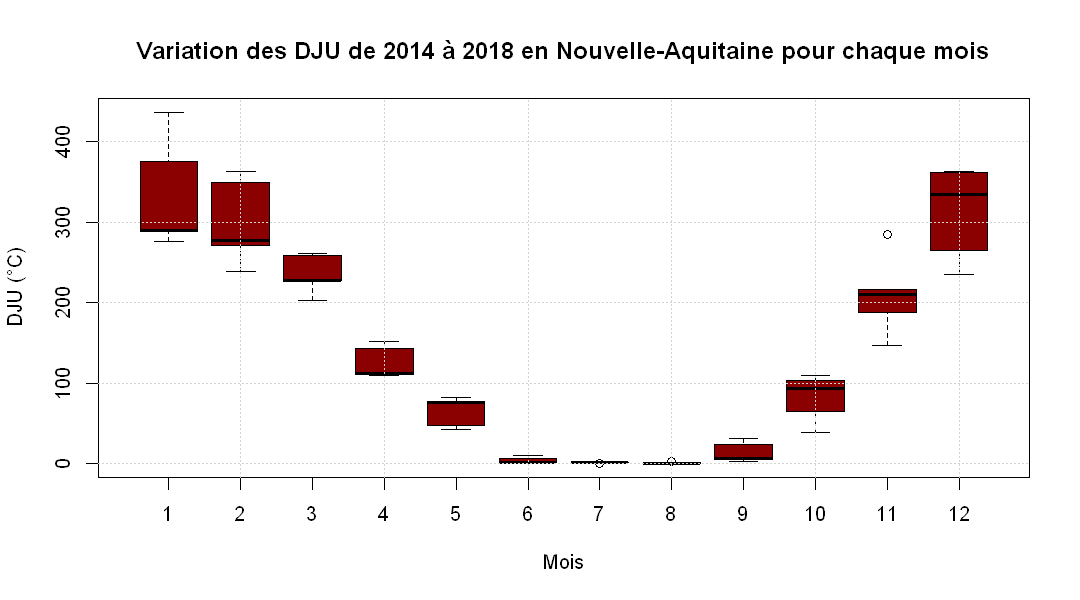

In [17]:
options(repr.plot.width = 9, repr.plot.height = 5)
boxplot(dju_ts ~ cycle(dju_ts), xlab = 'Mois', ylab = 'DJU (°C)', col = 'darkred', 
        main = 'Variation des DJU de 2014 à 2018 en Nouvelle-Aquitaine pour chaque mois')
grid()

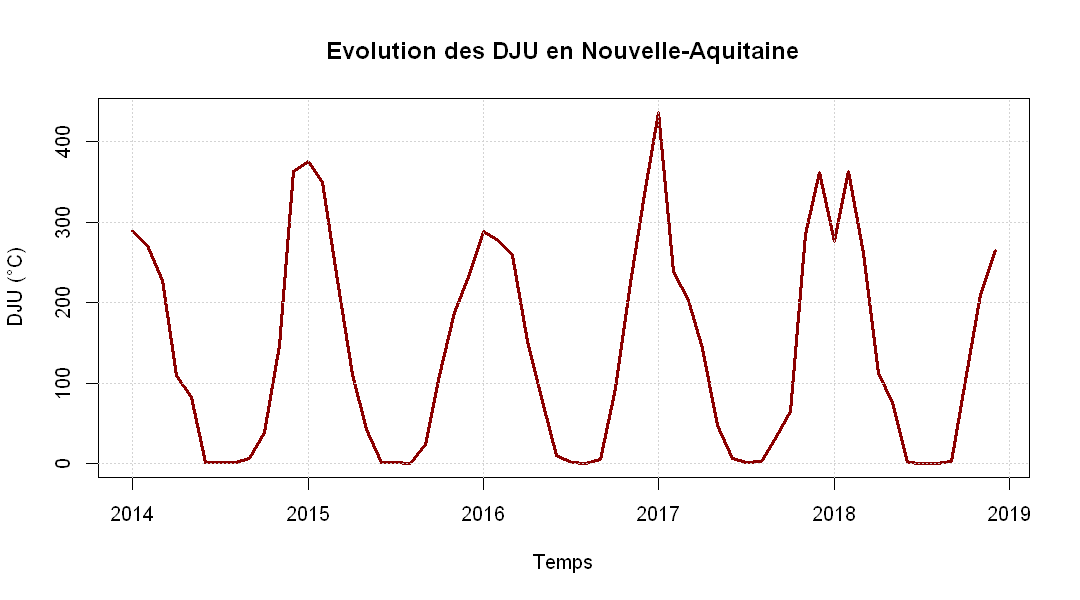

In [18]:
options(repr.plot.width = 9, repr.plot.height = 5)
plot(dju_ts, xlab = 'Temps', ylab = 'DJU (°C)', col = 'darkred', lw = 3, 
     main = 'Evolution des DJU en Nouvelle-Aquitaine')
grid()

CCL: Tendance stable, une saisonnalité additive de période 12.

<a href="#sommaire">Retour au sommaire</a>
# Mission 1<a name="M1"></a>
## <span style='color:blue'>1. Correction des données de consommation mensuelles de l'effet température par régression linéaire.<a name="M11"></a>

## <span style='color:brown'>a) Régression linéaire sur la série temporelle.<a name="M111"></a>

In [19]:
# Régression linéaire sur la série temporelle conso_ts:
reg <- lm(conso_ts ~ dju_ts)

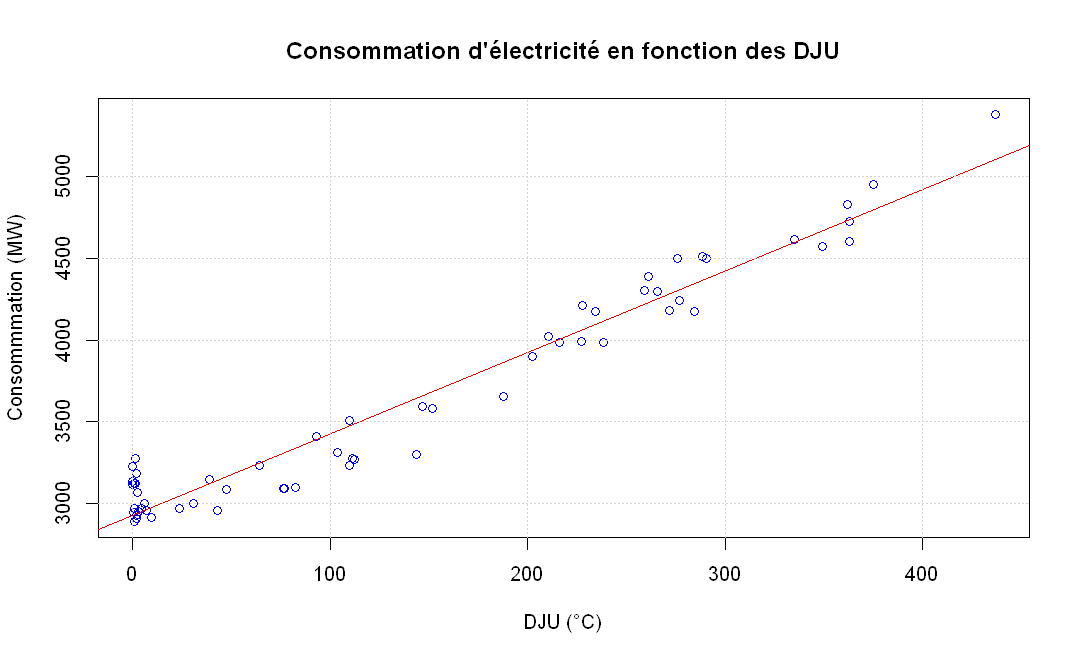

In [20]:
options(repr.plot.width = 9, repr.plot.height = 5.5)
plot(as.numeric(dju_ts), conso_ts, xlab = 'DJU (°C)', ylab = 'Consommmation (MW)', col = 'blue',
     main = 'Consommation d\'électricité en fonction des DJU')
abline(reg, col = 'red')
grid()

In [21]:
pearson <- cor(conso_ts, dju_ts, method = 'pearson')
cat('Coefficient de Pearson : ', round(pearson, 2))

Coefficient de Pearson :  0.97

Analysons la significativité globale du modèle en calculant la statistique de Fisher: 

Hypothèse nulle H0: tous les coefficients de la relation linéaire sont nuls.<br/>
Hypothèse alternative H1: un des coefficients au moins est non nul.<br/>
Test bilatéral.<br/>
Seuil de risque alpha fixé à 1%.<br/>
Si la p-value est inférieur au seuil de risque, le test est significatif.

In [22]:
summary(reg)


Call:
lm(formula = conso_ts ~ dju_ts)

Residuals:
    Min      1Q  Median      3Q     Max 
-338.91  -93.77   -5.27  108.88  341.67 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2929.8624    28.8127  101.69   <2e-16 ***
dju_ts         4.9724     0.1509   32.94   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 151.6 on 58 degrees of freedom
Multiple R-squared:  0.9493,	Adjusted R-squared:  0.9484 
F-statistic:  1085 on 1 and 58 DF,  p-value: < 2.2e-16


La p_value est inférieur à alpha, le test de Fisher est significatif: H0 est rejetée, un des coefficients au moins est non nul.<br/>
Il existe bien une relation linéaire entre les variables.

Notre modèle explique quasiment 95% de la variance totale. Il y a donc un très fort effet température dû au chauffage électrique.

Au vu des valeurs de "Residuals", la normalité des résidus est a priori assurée: la médiane est proche de 0 et les valeurs absolues de Q1 et de Q3 sont proches.

Le modèle de régression linéaire est viable si:
- les résidus suivent une loi normale.
- la variance des résidus est homoscédastique.
- les résidus sont indépendants et identiquement distribués.

### Evaluation de l’hypothèse de normalité des résidus

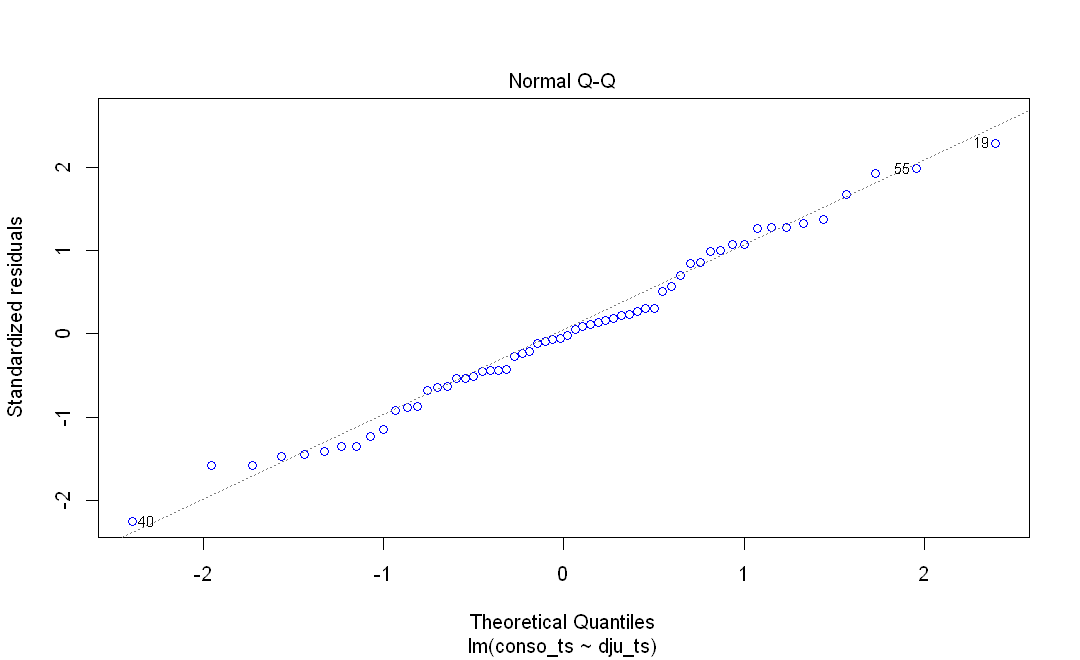

In [23]:
plot(reg, 2, col = 'blue')

CCL: Graphiquement, les résidus suivent une loi normale.

Test de Kolmogorov-Smirnov et de Jarque-Bera:

Hypothèse nulle H0: Les résidus sont gaussiens.<br/>
Hypothèse alternative H1 Les résidus ne sont pas gaussiens.<br/>
Test bilatéral et seuil de risque alpha fixé à 5%.

In [24]:
ks.test(resid(reg), 'pnorm', mean = mean(resid(reg)), sd = sd(resid(reg)))


	One-sample Kolmogorov-Smirnov test

data:  resid(reg)
D = 0.078627, p-value = 0.8238
alternative hypothesis: two-sided


In [25]:
ajb.norm.test(resid(reg))


	Adjusted Jarque-Bera test for normality

data:  resid(reg)
AJB = 0.62024, p-value = 0.7105


CCL: Les p-values sont supérieurs à alpha, les tests sont non significatifs: les résidus suivent donc une loi normale.

### Evaluation de l’hypothèse d’homogénéité des résidus:

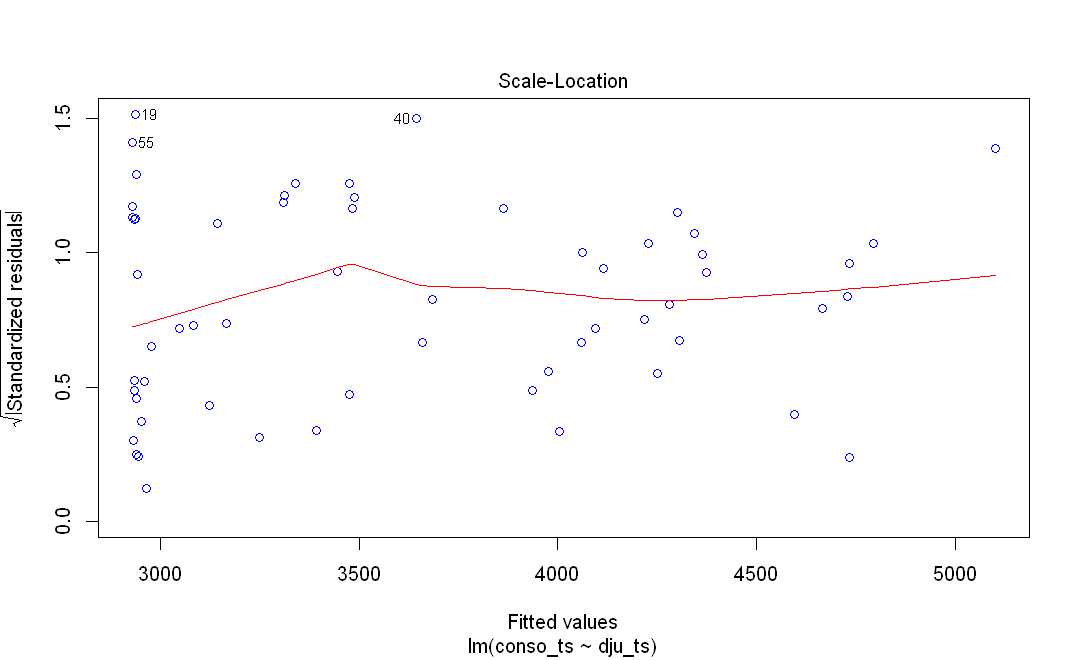

In [26]:
plot(reg, 3, col = 'blue')

CCL: La courbe rouge est globalement plate ce qui montre que les résidus ont tendance à être répartis de façon homogène tout le long du gradient des valeurs prédites, et donc que l’hypothèse d’homogénéité des résidus est acceptée.

Test de Breush-Pagan:

H0: Les valeurs des résidus ne dépendent pas des valeurs explicatives, il y a donc homoscédasticité de la variance résiduelle.<br/>
H1: Les valeurs résiduelles dépendent des valeurs prédictives, il y a alors hétéroscédasticité.<br/>
Test bilatéral et seuil de risque alpha estimé à 5%.

In [27]:
ncvTest(reg)

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.2501808, Df = 1, p = 0.61695

CCL: Le test ne rejette pas l'hypothèse d'homoscédasticité de la variance des résidus. 

### Evaluation de l’hypothèse d’indépendance des résidus.

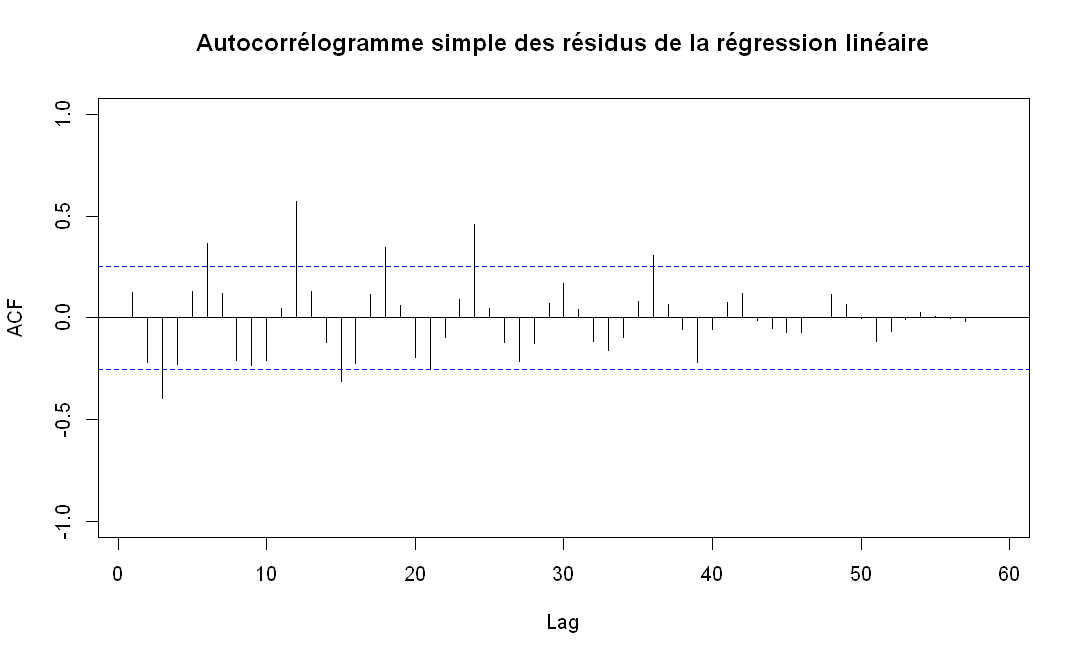

In [28]:
# Autocorrélogramme des résidus:
Acf(resid(reg), ylim = c(-1, 1), lag.max = length(resid(reg)), 
    main = 'Autocorrélogramme simple des résidus de la régression linéaire')

CCL: Les résidus indiquent une autocorrélation. Elle est notable sur les pics 12, 24 et 36. 

Test de Durbin-Watson:

Hypothèse H0: Il y a indépendance des résidus.<br/>
Hypothèse H1: Les résidus sont corrélées.<br/>
Test bilatéral et seuil de risque alpha à 1%.

In [29]:
durbinWatsonTest(reg)

 lag Autocorrelation D-W Statistic p-value
   1        0.126982      1.732256   0.234
 Alternative hypothesis: rho != 0

CCL: La p-value étant supérieur au seuil de risque, le test ne rejette pas H0: Les résidus sont indépendants.

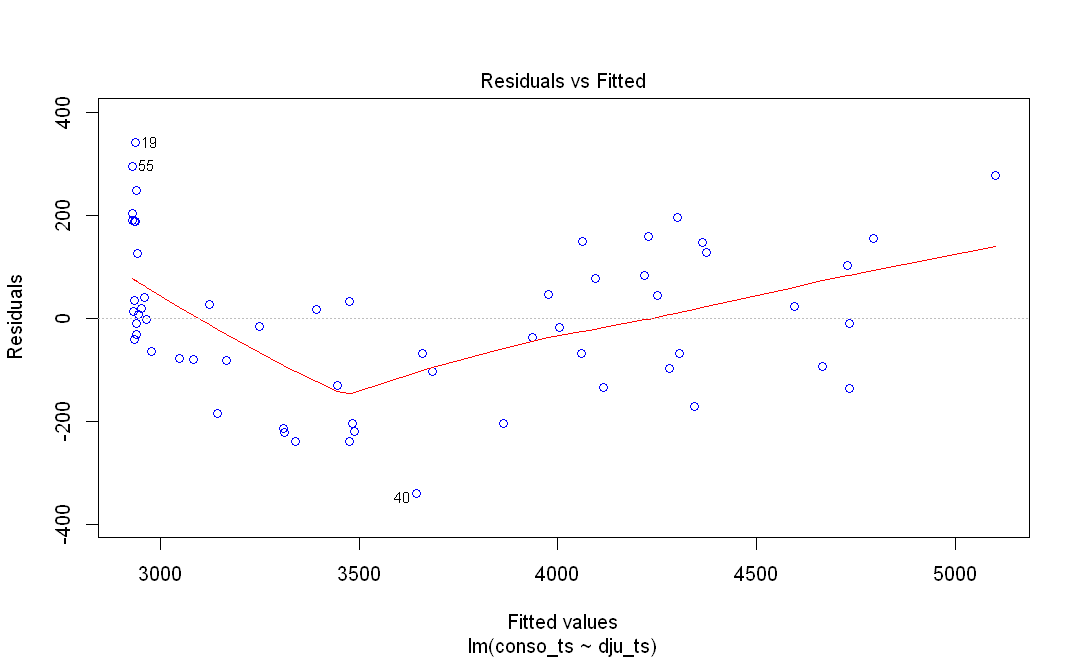

In [30]:
plot(reg, 1, col = 'blue')

CCL:
- On peut observer des résidus "couplés", censés indiquer une non-indépendance des résidus.
- Les valeurs prédites par le modèle augmentent, les résidus restent globalement uniformément distribués de part et d’autre de 0. Cela montre, qu’en moyenne, la droite de régression, est bien adaptée aux données, et donc que l’hypothèse de linéarité est acceptable.

En général, l'auto-corrélation des résidus (et donc la non-indépendance) se rencontre lorsque la variable prédictive est temporelle.<br/>
Au final, on considère notre modèle viable.<br/>
On peut passer à la correction proprement dite.

<a href="#sommaire">Retour au sommaire</a>
## <span style='color:brown'>b) Correction de l'effet température sur la consommation.<a name="M112"></a>

In [31]:
reg$coefficient[2]
conso_corr <- conso_ts - reg$coefficient[2]*dju_ts

dju_ts 
4.972437

$Consommation ~ corrigée = Consommation~totale - 4.97243674389088*DJU$

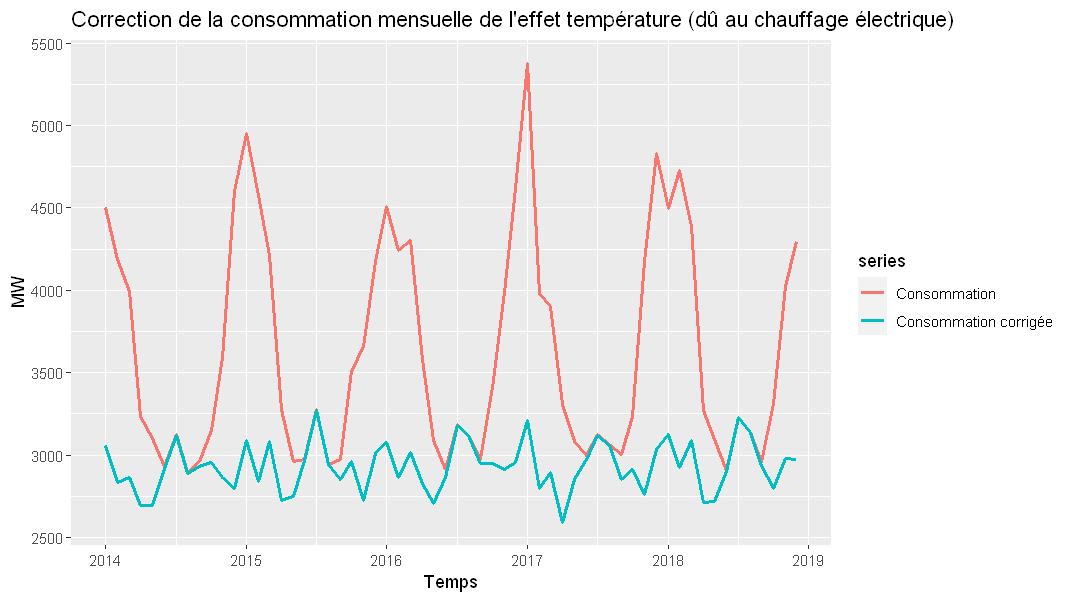

In [32]:
options(repr.plot.width = 9, repr.plot.height = 5)
autoplot(cbind(Consommation = conso_ts, 'Consommation corrigée' = conso_corr), xlab = 'Temps', ylab = 'MW', facets = F, size = 1, 
        main = 'Correction de la consommation mensuelle de l\'effet température (dû au chauffage électrique)')

CCL: On peut constater une sérieuse baisse de la consommation hivernale sans l'utilisation du chauffage électrique.

<a href="#sommaire">Retour au sommaire</a>
## <span style='color:blue'>2. Décomposition de la consommation corrigée.<a name="M12"></a>

In [33]:
# Décomposition de la consommation corrigée:
stl_conso_corr = stl(conso_corr, s.window = 'periodic')
summary(stl_conso_corr)

 Call:
 stl(x = conso_corr, s.window = "periodic")

 Time.series components:
    seasonal              trend            remainder         
 Min.   :-216.87184   Min.   :2864.235   Min.   :-145.45866  
 1st Qu.: -76.86474   1st Qu.:2921.282   1st Qu.: -50.67373  
 Median : -11.72846   Median :2931.423   Median :   3.25410  
 Mean   :   0.00000   Mean   :2929.619   Mean   :   0.24293  
 3rd Qu.:  71.68279   3rd Qu.:2947.537   3rd Qu.:  52.57235  
 Max.   : 252.21281   Max.   :2966.558   Max.   : 113.87746  
 IQR:
     STL.seasonal STL.trend STL.remainder data  
     148.55        26.25    103.25        202.66
   %  73.3         13.0      50.9         100.0 

 Weights: all == 1

 Other components: List of 5
 $ win  : Named num [1:3] 601 19 13
 $ deg  : Named int [1:3] 0 1 1
 $ jump : Named num [1:3] 61 2 2
 $ inner: int 2
 $ outer: int 0


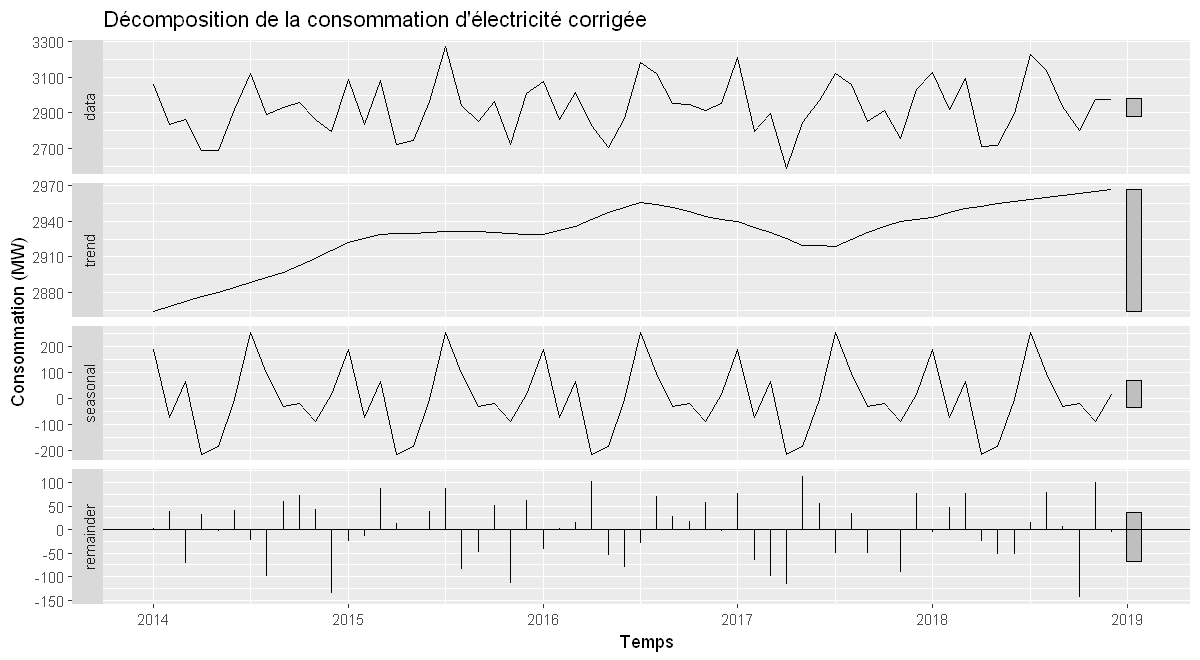

In [34]:
options(repr.plot.width = 10, repr.plot.height = 5.5)
autoplot(stl_conso_corr, xlab = 'Temps', ylab = 'Consommation (MW)', facets = F, size = 1, 
         main = 'Décomposition de la consommation d\'électricité corrigée')

In [35]:
# Taux d'évolution de la tendance pour la consommation corrigée:
round((stl_conso_corr$time.series[60, 2] - stl_conso_corr$time.series[1, 2])/stl_conso_corr$time.series[1, 2]*100, 1)

trend 
  3.6

- La tendance a évolué de 3.6% entre le 1er janvier 2014 et le 31 décembre 2018. Elle est donc considérée stable.
- La saisonnalité est de période 12.
- Montrons que les résidus sont des bruits blancs afin de confirmer l'exhaustivité de la décomposition.

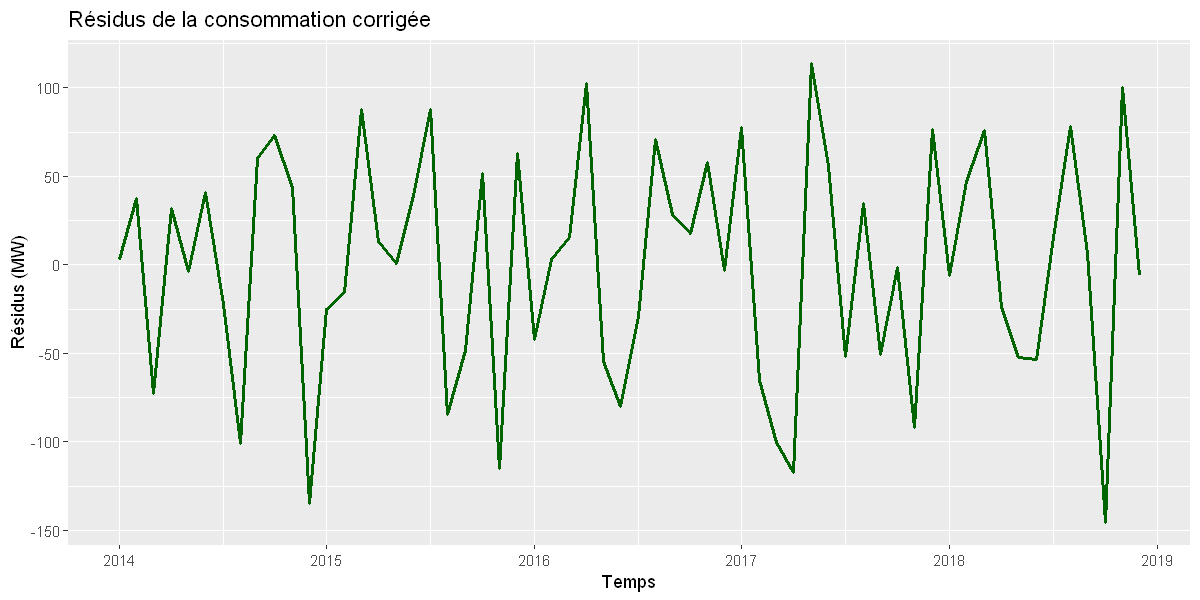

In [36]:
options(repr.plot.width = 10, repr.plot.height = 5)
autoplot(stl_conso_corr$time.series[, 3], size = 1, xlab = 'Temps', ylab = 'Résidus (MW)', col = 'darkgreen',
         main = 'Résidus de la consommation corrigée')

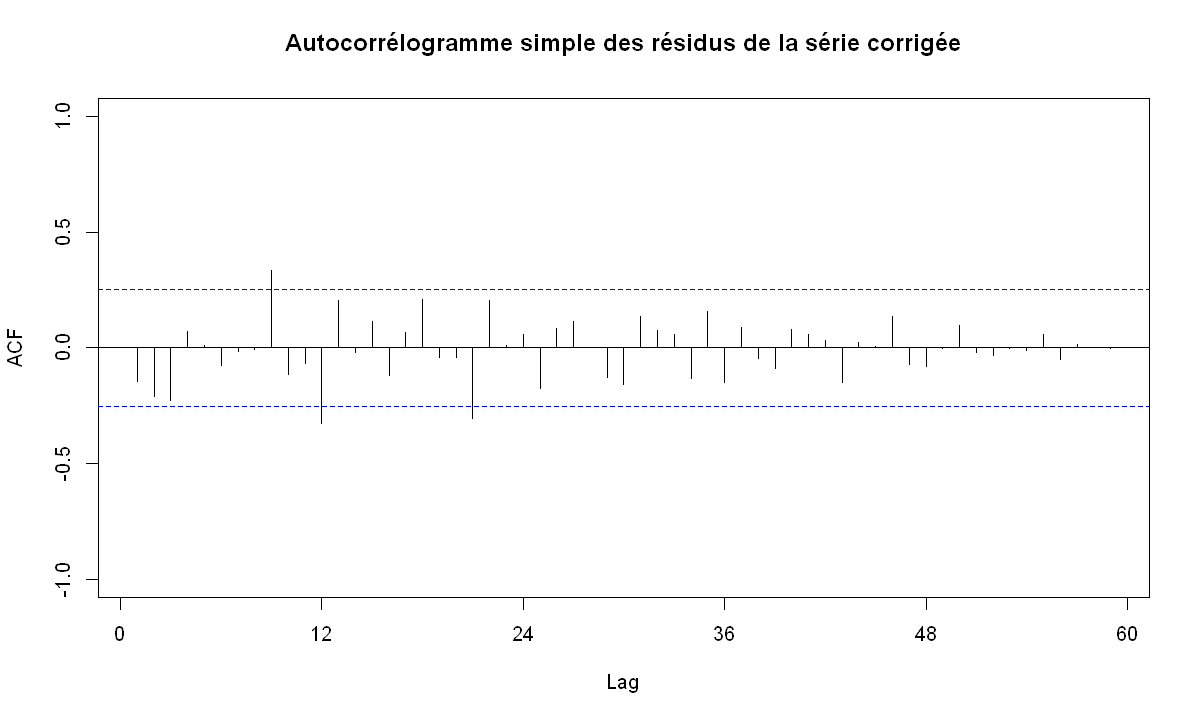

In [37]:
options(repr.plot.width = 10, repr.plot.height = 6)
Acf(stl_conso_corr$time.series[, 3], ylim = c(-1, 1), lag = max(nrow(conso)), 
    main = 'Autocorrélogramme simple des résidus de la série corrigée')

CCL: Visuellement, malgré trois pics légérement significatifs, il reste très peu d'informations dans les résidus utiles à la correction de l'effet température.<br/>
On peut visuellement considérer l'indépendances des résidus.

Tests de Llung-Box et Pierce-Box:

Hypothèse nulle H0: Les résidus sont des bruits blancs.<br/>
Hypothèse alternative H1: Les résidus ne sont pas des bruits blancs.<br/>
Test bilatéral et seuil de risque fixé à 1%.

In [38]:
Box.test(stl_conso_corr$time.series[, 3], lag = 20)


	Box-Pierce test

data:  stl_conso_corr$time.series[, 3]
X-squared = 29.079, df = 20, p-value = 0.08622


In [39]:
Box.test(stl_conso_corr$time.series[, 3], lag = 20, type = 'Lj')


	Box-Ljung test

data:  stl_conso_corr$time.series[, 3]
X-squared = 36.193, df = 20, p-value = 0.0146


Les tests ne rejettent pas H0 au niveau de 1%: Les résidus sont des bruits blancs.  

Test de Shapiro-Wilk:

Hypothèse nulle H0: Les résidus suivent une loi normale.<br/>
Hypothèse alternative H1: Les résidus ne suivent pas une loi normale.<br/>
Test bilatéral et seuil de risque fixé à 1%.

In [40]:
shapiro.test(stl_conso_corr$time.series[, 3])


	Shapiro-Wilk normality test

data:  stl_conso_corr$time.series[, 3]
W = 0.97162, p-value = 0.175


CCL: Le test de normalité des résidus est confirmé pour cette décomposition au niveau de 5%.

Au final, nos résidus sont des bruits blancs gaussiens.<br/>
L'exhaustivité de la décomposition de la consommation corrigée est confirmée.<br/>
Notre décompostion est donc viable.

<a href="#sommaire">Retour au sommaire</a>
# Mission 2<a name="M2"></a>
# <span style='color:red'>Désaisonnalisation de la consommation corrigée grâce aux moyennes mobiles.<a name="M21"></a>

In [41]:
# Saisonnalité:
saisonnalite <- stl_conso_corr$time.series[, 1]

# Désaisonnalisation:
desaisonnalisation <- conso_corr - saisonnalite

$désaisonnalisation = consommation~corrigée - saisonnalité$

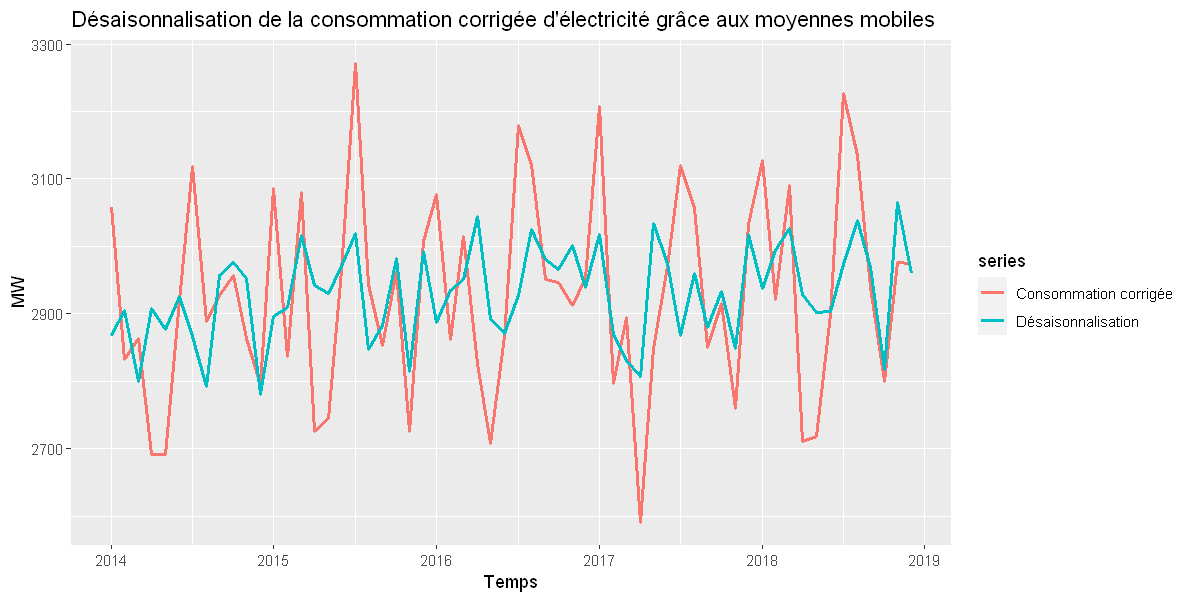

In [42]:
options(repr.plot.width = 10, repr.plot.height = 5)
autoplot(cbind('Consommation corrigée' = conso_corr, Désaisonnalisation = desaisonnalisation), xlab = 'Temps', ylab = 'MW', 
         facets = F, size = 1, main = 'Désaisonnalisation de la consommation corrigée d\'électricité grâce aux moyennes mobiles')

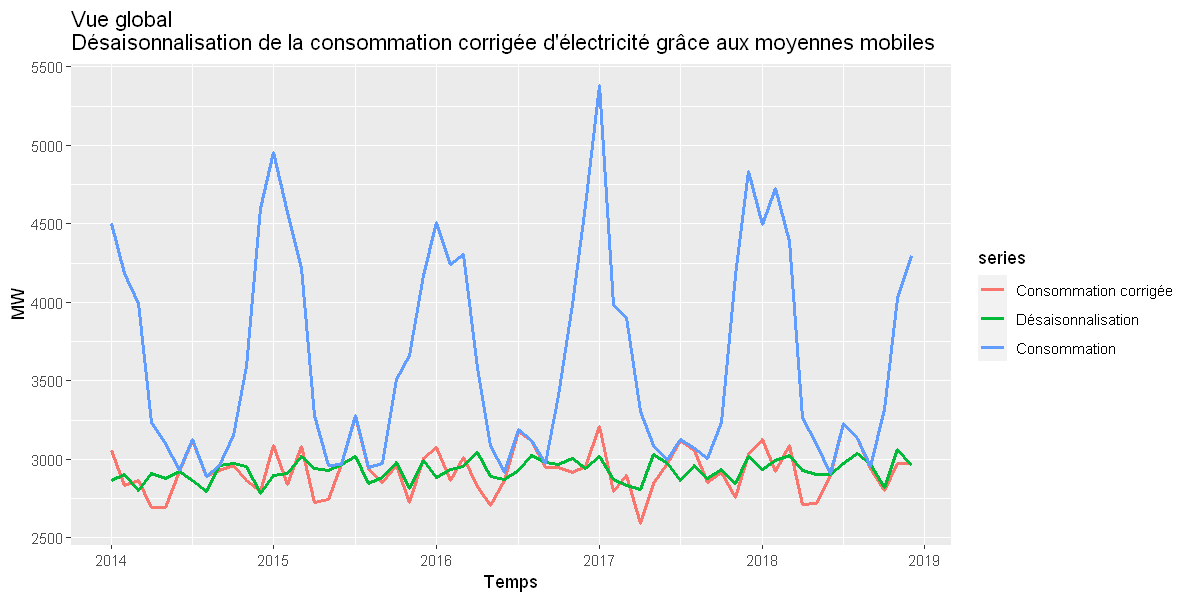

In [43]:
options(repr.plot.width = 10, repr.plot.height = 5)
autoplot(cbind('Consommation corrigée' = conso_corr, Désaisonnalisation = desaisonnalisation, 'Consommation' = conso_ts), 
         xlab = 'Temps', ylab = 'MW', facets = F, size = 1,
         main = 'Vue global\nDésaisonnalisation de la consommation corrigée d\'électricité grâce aux moyennes mobiles')

<a href="#sommaire">Retour au sommaire</a>
# Mission 3<a name="M3"></a>
# <span style='color:red'>Prévision de la consommation corrigée sur un an.<a name="M31"></a>

## <span style='color:blue'>1. Méthode de Holt-Winters.<a name="M311"></a>

Cette méthode se sert de trois équations de lissage fonction des paramètres suivants:
- Paramètre α : lissage sur les valeurs<br/>
- Paramètre β : lissage sur la tendance<br/>
- Paramètre γ : lissage sur la saisonnalité<br/>

## <span style='color:brown'>a) Modèle de Holt-Winters additif avec erreurs additives.<a name="M31"></a>

D'après les premières analyses de la consommmation sur sa tendance et sa saisonnalité, on a envie d'utiliser un modèle AAA (Erreurs additives, Tendance additive et Saisonnalité additive).<br/>
Essayons alors ce premier modèle:

In [44]:
# Méthode de Holt-Winters :
hw_aaa = ets(conso_corr, model = 'AAA')
hw_aaa.pred = predict(hw_aaa, 12)
summary(hw_aaa.pred)


Forecast method: ETS(A,A,A)

Model Information:
ETS(A,A,A) 

Call:
 ets(y = conso_corr, model = "AAA") 

  Smoothing parameters:
    alpha = 0.0035 
    beta  = 0.0022 
    gamma = 0.001 

  Initial states:
    l = 2892.6714 
    b = 1.0129 
    s = 19.3585 -94.7408 16.0517 -27.3752 83.4995 246.123
           -29.5753 -178.5787 -215.9712 81.1986 -78.0189 178.0288

  sigma:  80.9957

     AIC     AICc      BIC 
788.3789 802.9504 823.9828 

Error measures:
                   ME     RMSE      MAE         MPE     MAPE      MASE
Training set 1.335345 69.36058 55.86644 -0.01112165 1.922059 0.5757928
                    ACF1
Training set -0.05138024

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2019       3149.416 3045.616 3253.216 2990.667 3308.165
Feb 2019       2894.529 2790.727 2998.331 2735.778 3053.280
Mar 2019       3054.824 2951.019 3158.629 2896.068 3213.580
Apr 2019       2758.932 2655.121 2862.742 2600.167 2917.696
May 2019       2797.487 2693.669 290

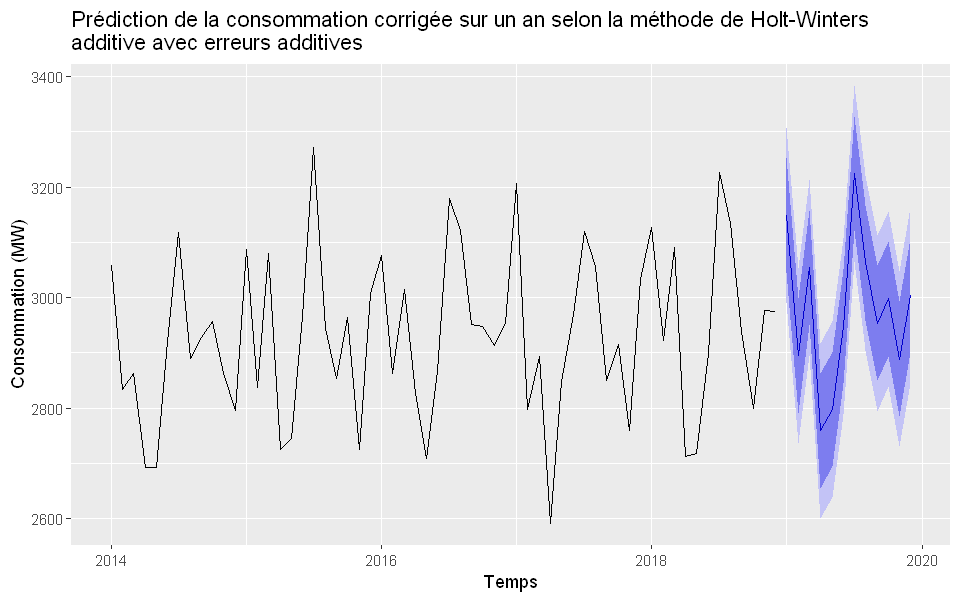

In [45]:
options(repr.plot.width = 8, repr.plot.height = 5)
autoplot(hw_aaa.pred, xlab = 'Temps', ylab = 'Consommation (MW)',
         main = 'Prédiction de la consommation corrigée sur un an selon la méthode de Holt-Winters\nadditive avec erreurs additives')

## <span style='color:brown'>b) Modèle de Holt-Winters additif avec erreurs multiplicatives.<a name="M32"></a>

Laissons choisir le modèle selon la commande ETS:

In [46]:
# Méthode de Holt-Winters :
hw_zzz = ets(conso_corr, model = 'ZZZ')
hw_zzz.pred = predict(hw_zzz, 12)
summary(hw_zzz.pred)


Forecast method: ETS(M,N,A)

Model Information:
ETS(M,N,A) 

Call:
 ets(y = conso_corr, model = "ZZZ") 

  Smoothing parameters:
    alpha = 8e-04 
    gamma = 3e-04 

  Initial states:
    l = 2929.0827 
    s = 15.065 -85.1678 3.8746 -35.9209 95.3809 254.7457
           -11.2126 -192.6391 -215.1517 60.3082 -68.785 179.5027

  sigma:  0.0273

     AIC     AICc      BIC 
785.5761 796.4852 816.9912 

Error measures:
                   ME     RMSE      MAE         MPE     MAPE     MASE
Training set 1.018219 70.00868 57.06268 -0.02320774 1.951601 0.588122
                      ACF1
Training set -0.0002615054

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2019       3108.635 2999.695 3217.575 2942.026 3275.244
Feb 2019       2860.330 2760.092 2960.568 2707.029 3013.631
Mar 2019       2989.436 2884.673 3094.199 2829.215 3149.657
Apr 2019       2713.971 2618.862 2809.080 2568.514 2859.428
May 2019       2736.498 2640.600 2832.397 2589.834 2883.163
Jun 2019      

CCL:
- La prédiction se base sur un modèle avec Erreur multiplicative et Saisonnalité Additive: le paramètre Beta (lissage sur la tendance) est inexistant.
- L'erreur moyenne absolu entre les valeurs observés et prédites (MAPE) entre les deux modèles différent de 3 centième de pourcentage en faveur du premier.
- L'$AIC_c$ du deuxième modèle est un peu plus bas de 7 unités. Cela incite à conserver le dernière modèle.

Remarque:<br/>
Les valeurs de alpha proches de 1 réduisent l'incidence du passé et donnent plus de poids aux valeurs récentes, et inversement, les valeurs proches de 0 augmentent le lissage et réduisent l'incidence des valeurs récentes.<br/>
Or les équations de lissage  sous forme de correction d'erreur peuvent s'écrivent en fonction de alpha (proche de zéro dans les deux cas).<br/>
Les prédictions se font donc en fonction de toutes les valeurs passées dans les deux modèles.

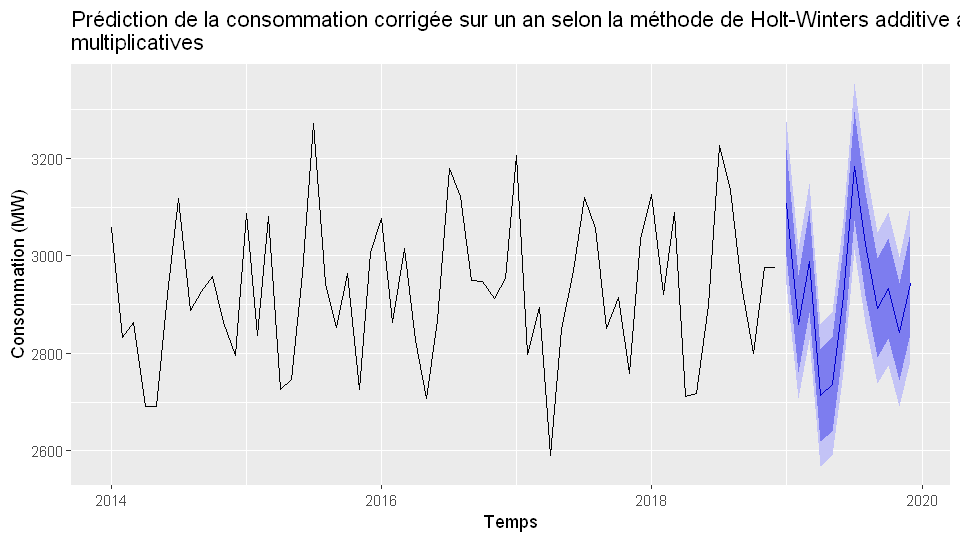

In [47]:
options(repr.plot.width = 8, repr.plot.height = 4.5)
autoplot(hw_zzz.pred, xlab = 'Temps', ylab = 'Consommation (MW)',
         main = 'Prédiction de la consommation corrigée sur un an selon la méthode de Holt-Winters additive avec erreurs\nmultiplicatives')

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Warning message:
"Removed 48 row(s) containing missing values (geom_path)."

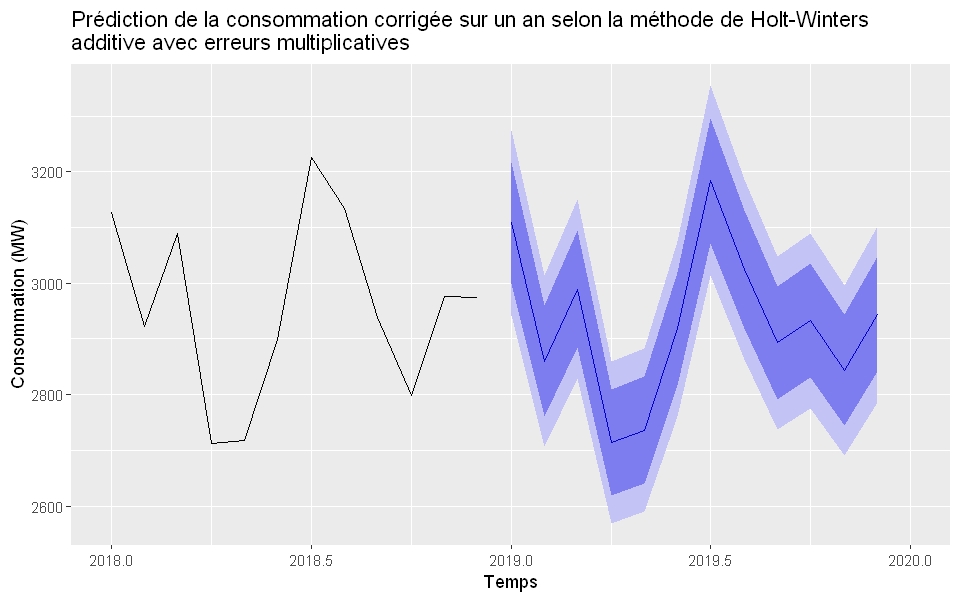

In [48]:
options(repr.plot.width = 8, repr.plot.height = 5)
autoplot(hw_zzz.pred, xlim = c(2018, 2020), xlab = 'Temps', ylab = 'Consommation (MW)',
         main = 'Prédiction de la consommation corrigée sur un an selon la méthode de Holt-Winters\nadditive avec erreurs multiplicatives')

<a href="#sommaire">Retour au sommaire</a>
## <span style='color:blue'>2. Méthode SARIMA.<a name="M312"></a>
## <span style='color:brown'>a) Détermination du modèle.<a name="M3121"></a>
### Stationnarité:

On regarde la stationnarité de la série "consommation corrigée":

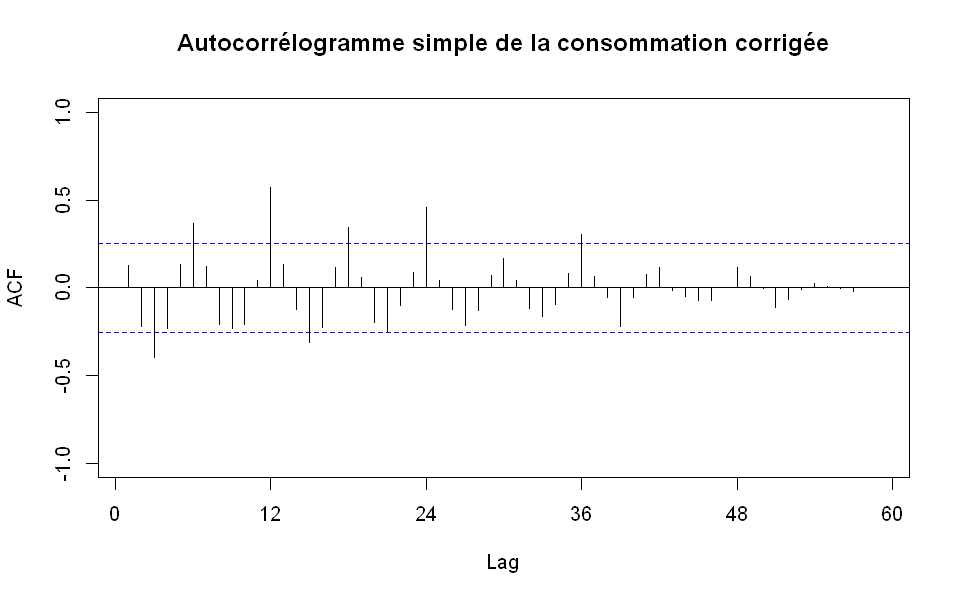

In [49]:
options(repr.plot.width = 8, repr.plot.height = 5)
Acf(conso_corr, length(conso_corr), ylim = c(-1, 1), main = 'Autocorrélogramme simple de la consommation corrigée')

CCL: On observe notamment des pics tous les 12 mois. La série décroît trop lentement vers 0, elle n'est visuellement pas stationnaire.
Les autocorrélations simples ρ(h) ne sont ni proches de 1, ni proches les unes des autres. Ainsi, on n'effectue pas une différenciation en tendance.

Test de Dickey-Fuller augmenté:

H0: La série comporte une racine unitaire.<br/>
H1: La série ne comporte pas de racine unitaire. Elle est stationnaire.<br/>
Test bilatéral et seuil de risque fixé à 1%.

In [50]:
adf.test(conso_corr)

Warning message in adf.test(conso_corr):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  conso_corr
Dickey-Fuller = -6.8999, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


CCL: Le test est non significatif au niveau 1%:  La série a une racine unitaire. Elle n'est donc pas stationnaire.

In [51]:
# Calcul du nombre de différenciation sur les différentes parties à effectuer:
cat('Nombre de différenciation de la partie non saisonnière:', ndiffs(conso_corr),'\n')
cat('Nombre de différenciation de la partie saisonnière:', nsdiffs(conso_corr),'\n')

Nombre de différenciation de la partie non saisonnière: 0 
Nombre de différenciation de la partie saisonnière: 1 


On effectue alors une différenciation en saisonnalité avec s = 12 de la série pour tenter d'obtenir une série stationnaire.

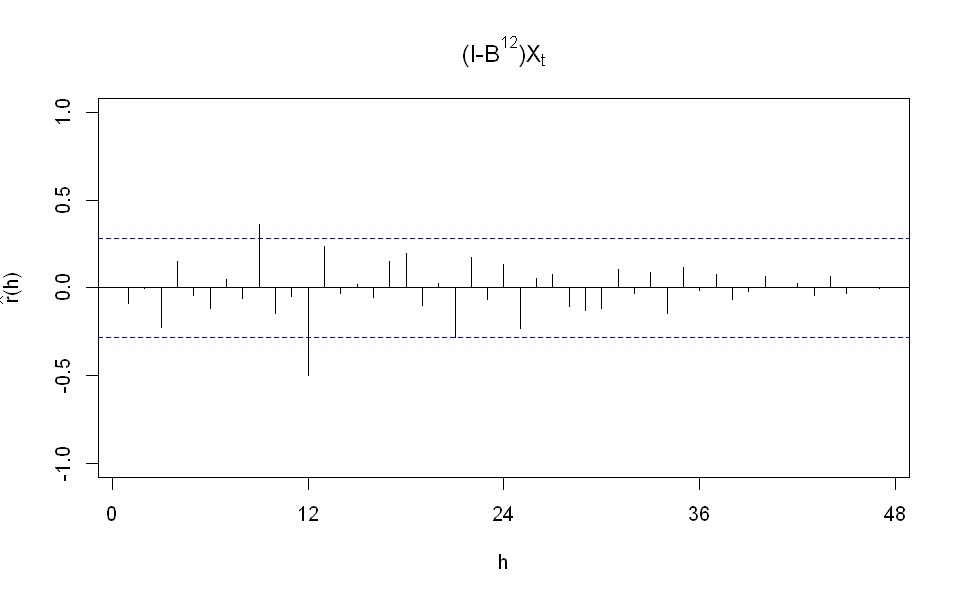

In [52]:
options(repr.plot.width = 8, repr.plot.height = 5)
Acf(diff(conso_corr, lag = 12, differences = 1), ylim = c(-1, 1), xlab = 'h', ylab = TeX('$\\widehat{r}(h)$'), lag = 48, 
    main = TeX('$(I-B^{12})X_t$'))

La sortie ACF de la série différenciée semble pouvoir être interprétable comme un autocorrélogramme simple empirique.<br/>

On vérifie que la série différenciée est bien devenue stationnaire:

Test de Phillips-Perron:

H0: La série différenciée n'est pas stationnaire.<br/>
H1: La série différenciée est stationnaire.<br/>
Test bilatéral et seuil de risque fixé à 5%.

In [53]:
pp.test(diff(conso_corr, lag = 12, differences = 1))

Warning message in pp.test(diff(conso_corr, lag = 12, differences = 1)):
"p-value smaller than printed p-value"


	Phillips-Perron Unit Root Test

data:  diff(conso_corr, lag = 12, differences = 1)
Dickey-Fuller Z(alpha) = -47.762, Truncation lag parameter = 3, p-value
= 0.01
alternative hypothesis: stationary


CCL: La p-value est inférieur au seuil de risque 5%. Le processus est stationnaire.<br/>
Remarque: Avec un seuil de risque fixé à 1%, ça ne marche pas.<br/>
On va donc tester une autre méthode: on teste la blancheur de cette série puis on teste sa normalité.
Si les deux conditions sont réunies, la série sera composée de bruits blancs gaussiens: elle sera alors stationnaire. 

Test de Llung-Box:

Hypothèse nulle H0: La série est composé sont de bruits blancs.<br/>
Hypothèse alternative H1: La série n'est pas composé de bruits blancs.<br/>
Test bilatéral et seuil de risque fixé à 1%.

In [54]:
Box.test(diff(conso_corr, lag = 12, differences = 1), type = 'Ljung-Box') 


	Box-Ljung test

data:  diff(conso_corr, lag = 12, differences = 1)
X-squared = 0.39099, df = 1, p-value = 0.5318


CCL: La p-value est supérieur au seuil de risque: Le test ne rejette pas H0, la série différenciée est composé de bruits blancs.

Test de Shapiro-Wilk:

Hypothèse nulle H0: La série suit une loi normale.<br/>
Hypothèse alternative H1: La série ne suit pas une loi normale.<br/>
Test bilatéral et seuil de risque fixé à 5%.

In [55]:
shapiro.test(diff(conso_corr, lag = 12, differences = 1))


	Shapiro-Wilk normality test

data:  diff(conso_corr, lag = 12, differences = 1)
W = 0.9689, p-value = 0.2295


CCL: Le test est non significatif à un niveau de 5%: La série suit une loi normale.<br/>
On peut donc conclure que la série différenciée est composée de bruits blancs gaussiens, elle est donc bien stationnaire.

On identifiera donc un modèle SARIMA sur la série (p, 0, q)(P, 1, Q)[12].

On regarde maintenant les autocorrélogrammes partiels et simple de cette série stationnaire afin de déterminer les autres coefficients du modèle:

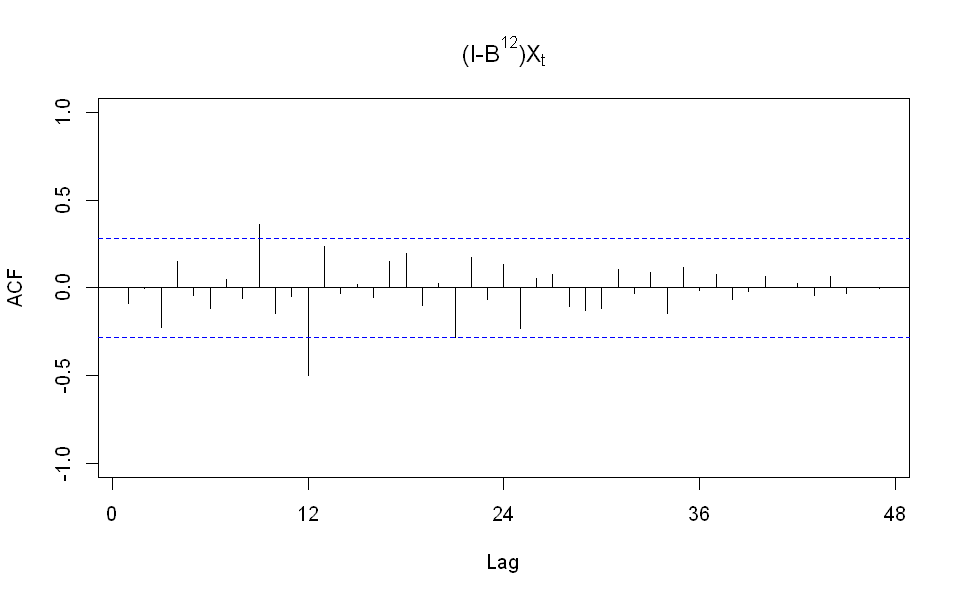

In [56]:
options(repr.plot.width = 8, repr.plot.height = 5)
Acf(diff(conso_corr, lag = 12, differences = 1), ylim = c(-1, 1), lag = 48, main = TeX('$(I-B^{12})X_t$'))

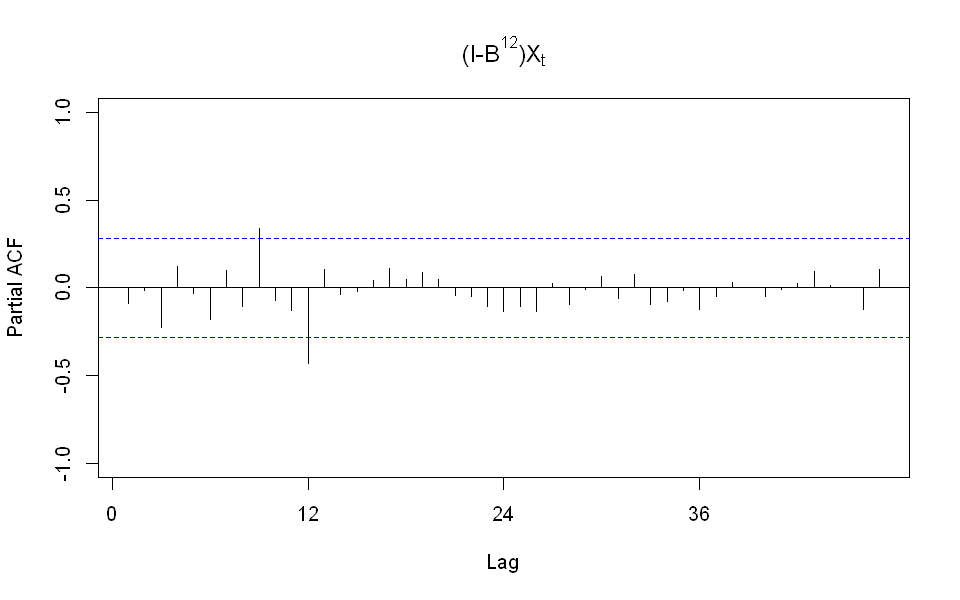

In [57]:
options(repr.plot.width = 8, repr.plot.height = 5)
Pacf(diff(conso_corr, lag = 12, differences = 1), ylim = c(-1, 1), lag = 48, main = TeX('$(I-B^{12})X_t$'))

CCL:
- Décroissance sinusoïdale pour ACF et PACF.
- Un pic en 9 légèrement significatif pour PCAF donc p = 0 ou 1.
- Un pic en 12 correspondant à la saisonnalité pour PACF donc P = 1.
- Un pic en 12 correspondant à la saisonnalité pour ACF donc Q = 1.
- Un pic en 9 légèrement significatif pour ACF donc q = 0 ou 1.

<a href="#sommaire">Retour au sommaire</a>
## <span style='color:brown'>b) Validation du modèle.<a name="M3122"></a>

On peut donc déjà tester les modèles suivants:
- SARIMA(0, 0, 0)(1, 1, 1)[12]
- SARIMA(1, 0, 0)(1, 1, 1)[12]
- SARIMA(0, 0, 1)(1, 1, 1)[12]
- SARIMA(1, 0, 1)(1, 1, 1)[12]

### Modèle SARIMA(0, 0, 0)(1, 1, 1)[12]:

In [58]:
model1 <- Arima(conso_corr, order = c(0, 0, 0), list(order = c(1, 1, 1), period = 12), include.mean = F, method = 'CSS-ML')
summary(model1)

# Test de significativité des paramètres dans le modèle:
t_stat(model1)

# Test de blancheur des résidus du modèle:
Box.test.2(model1$residuals, nlag = c(6,12,18,24,30,36), type = 'Ljung-Box', decim = 5)

# Test de normalité des résidus:
shapiro.test(model1$residuals)

Series: conso_corr 
ARIMA(0,0,0)(1,1,1)[12] 

Coefficients:
         sar1     sma1
      -0.5556  -0.2322
s.e.   0.1934   0.2508

sigma^2 estimated as 7275:  log likelihood=-284.5
AIC=574.99   AICc=575.54   BIC=580.61

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set 19.98003 74.68198 53.51651 0.6221272 1.815541 0.5515731
                     ACF1
Training set -0.002989593


,sar1,sma1
t.stat,-2.873145,-0.925853
p.val,0.004064,0.354523


Retard,p-value
6,0.60180
12,0.40513
18,0.48218
24,0.67932
30,0.81225
36,0.92047



	Shapiro-Wilk normality test

data:  model1$residuals
W = 0.96375, p-value = 0.07189


CCL:
- Le test rejette l'hypothèse nulle pour le paramètre des moyennes mobiles saisonnières: ce paramètres est significativement différent de zéro dans le modèle au niveau de 5%.
- Le test rejette H0 au niveau de 5%: Les résidus sont des bruits blancs.
- Le test ne rejette pas l'hypothèse de normalité des résidus au niveau 1%: Les résidus sont des bruits blancs Gaussiens.
- Le MAPE est très bon (1.8%).

Dans la continuité de recherche de viabilité, on reteste alors le modèle 1 en passant le paramètre Q à 0:

### Modèle SARIMA(0, 0, 0)(1, 1, 0)[12]:

In [59]:
model1 <- Arima(conso_corr, order = c(0, 0, 0), list(order = c(1, 1, 0), period = 12), include.mean = F, method = 'CSS-ML')
summary(model1)

# Test de significativité des paramètres dans le modèle:
t_stat(model1)

# Test de blancheur des résidus du modèle:
Box.test.2(model1$residuals, nlag = c(6,12,18,24,30,36), type = 'Ljung-Box', decim = 5)

# Test de normalité des résidus:
shapiro.test(model1$residuals)

Series: conso_corr 
ARIMA(0,0,0)(1,1,0)[12] 

Coefficients:
         sar1
      -0.6759
s.e.   0.1058

sigma^2 estimated as 7357:  log likelihood=-284.94
AIC=573.88   AICc=574.15   BIC=577.62

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE       ACF1
Training set 17.98963 75.91558 53.42757 0.5543823 1.814652 0.5506564 0.04491739


,sar1
t.stat,-6.390891
p.val,0.000000


Retard,p-value
6,0.48144
12,0.18943
18,0.24122
24,0.42217
30,0.59022
36,0.77469



	Shapiro-Wilk normality test

data:  model1$residuals
W = 0.95551, p-value = 0.02848


CCL: Parfait!

<a href="#sommaire">Retour au sommaire</a>
### Modèle SARIMA(1, 0, 0)(1, 1, 1)[12]:

In [60]:
model2 <- Arima(conso_corr, order = c(1, 0, 0), list(order = c(1, 1, 1), period = 12), include.mean = F, method = 'CSS-ML')
summary(model2)

# Test de significativité des paramètres dans le modèle:
t_stat(model2)

# Test de blancheur des résidus du modèle:
Box.test.2(model2$residuals, nlag = c(6,12,18,24,30,36), type = 'Ljung-Box', decim = 5)

# Test de normalité des résidus:
shapiro.test(model2$residuals)

Series: conso_corr 
ARIMA(1,0,0)(1,1,1)[12] 

Coefficients:
         ar1     sar1     sma1
      0.0647  -0.5813  -0.2058
s.e.  0.1499   0.1976   0.2577

sigma^2 estimated as 7381:  log likelihood=-284.4
AIC=576.81   AICc=577.74   BIC=584.29

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set 18.57523 74.40039 52.81473 0.5747391 1.791818 0.5443401
                    ACF1
Training set -0.04596514


,ar1,sar1,sma1
t.stat,0.431374,-2.942216,-0.798421
p.val,0.666196,0.003259,0.424626


Retard,p-value
6,0.59114
12,0.39082
18,0.46248
24,0.65177
30,0.79289
36,0.90699



	Shapiro-Wilk normality test

data:  model2$residuals
W = 0.96022, p-value = 0.04823


CCL:
- Deux paramètres sont significativement différent de zéro: Le modèle ne sera pas conservé.
- Les résidus sont des bruits blancs gaussiens aux niveaux de 1%.
- Le MAPE est de 1.8%.

<a href="#sommaire">Retour au sommaire</a>
### Modèle SARIMA(0, 0, 1)(1, 1, 1)[12]:

In [61]:
model3 <- Arima(conso_corr, order = c(0, 0, 1), list(order = c(1, 1, 1), period = 12), include.mean = F, method = 'CSS-ML')
summary(model3)

# Test de significativité des paramètres dans le modèle:
t_stat(model3)

# Test de blancheur des résidus du modèle:
Box.test.2(model3$residuals, nlag = c(6,12,18,24,30,36), type = 'Ljung-Box', decim = 5)

# Test de normalité des résidus:
shapiro.test(model3$residuals)

Series: conso_corr 
ARIMA(0,0,1)(1,1,1)[12] 

Coefficients:
        ma1     sar1     sma1
      0.088  -0.5933  -0.1949
s.e.  0.174   0.2022   0.2617

sigma^2 estimated as 7352:  log likelihood=-284.37
AIC=576.74   AICc=577.67   BIC=584.22

Training set error measures:
                   ME    RMSE      MAE       MPE     MAPE      MASE        ACF1
Training set 18.18102 74.2549 52.49387 0.5616355 1.780909 0.5410332 -0.06138417


,ma1,sar1,sma1
t.stat,0.505588,-2.934309,-0.744758
p.val,0.613146,0.003343,0.456418


Retard,p-value
6,0.60585
12,0.40200
18,0.47173
24,0.65572
30,0.79430
36,0.90663



	Shapiro-Wilk normality test

data:  model3$residuals
W = 0.95939, p-value = 0.04393


CCL:
- Deux paramètres sont significativement différent de zéro.
- Les résidus sont des bruits blancs gaussiens aux niveaux de 1%.
- Le MAPE est de 1.8%.

Au final, le modèle ne sera pas conservé.

<a href="#sommaire">Retour au sommaire</a>
### Modèle SARIMA(1, 0, 1)(1, 1, 1)[12]:

In [62]:
model4 <- Arima(conso_corr, order = c(1, 0, 1), list(order = c(1, 1, 1), period = 12), include.mean = F, method = 'CSS-ML')
summary(model4)

# Test de significativité des paramètres dans le modèle:
t_stat(model4)

# Test de blancheur des résidus du modèle:
Box.test.2(model4$residuals, nlag = c(6,12,18,24,30,36), type = 'Ljung-Box', decim = 5)

# Test de normalité des résidus:
shapiro.test(model4$residuals)

Series: conso_corr 
ARIMA(1,0,1)(1,1,1)[12] 

Coefficients:
          ar1     ma1     sar1     sma1
      -0.8581  1.0000  -0.5778  -0.2233
s.e.   0.1054  0.0815   0.1882   0.2507

sigma^2 estimated as 6973:  log likelihood=-283.81
AIC=577.63   AICc=579.06   BIC=586.99

Training set error measures:
                   ME    RMSE      MAE       MPE    MAPE      MASE       ACF1
Training set 18.38866 71.5102 49.97529 0.5724696 1.69709 0.5150752 -0.0585468


,ar1,ma1,sar1,sma1
t.stat,-8.137197,12.27702,-3.070544,-0.890642
p.val,0.000000,0.00000,0.002137,0.373121


Retard,p-value
6,0.71069
12,0.53567
18,0.59684
24,0.78367
30,0.88123
36,0.94753



	Shapiro-Wilk normality test

data:  model4$residuals
W = 0.95222, p-value = 0.01984


CCL: au vu des résultats, on teste le modèle SARIMA(1, 0, 1)(1, 1, 0)[12]: la significativité des paramètres n'est pas concluantes.

Au final, le modèle SARIMA(0, 0, 0)(1, 1, 0)[12] est le seul viable.

<a href="#sommaire">Retour au sommaire</a>
### Modèle déterminé par la commande auto.arima:

In [63]:
(autoarima <-auto.arima(conso_corr, seasonal = T, stepwise = F, approximation = F))

# Test de significativité des paramètres dans le modèle:
t_stat(autoarima)

# Test de blancheur des résidus du modèle:
Box.test.2(autoarima$residuals, nlag = c(6,12,18,24,30,36), type = 'Ljung-Box', decim = 5)

# Test de normalité des résidus:
shapiro.test(autoarima$residuals)

Series: conso_corr 
ARIMA(0,0,0)(1,1,0)[12] with drift 

Coefficients:
         sar1   drift
      -0.6816  1.0331
s.e.   0.1034  0.6649

sigma^2 estimated as 7129:  log likelihood=-283.75
AIC=573.51   AICc=574.06   BIC=579.12

,sar1,drift
t.stat,-6.591171,1.553826
p.val,0.000000,0.120226


Retard,p-value
6,0.46305
12,0.21717
18,0.24185
24,0.43148
30,0.59655
36,0.79008



	Shapiro-Wilk normality test

data:  autoarima$residuals
W = 0.95398, p-value = 0.02406



	Ljung-Box test

data:  Residuals from ARIMA(0,0,0)(1,1,0)[12] with drift
Q* = 18.307, df = 10, p-value = 0.05

Model df: 2.   Total lags used: 12



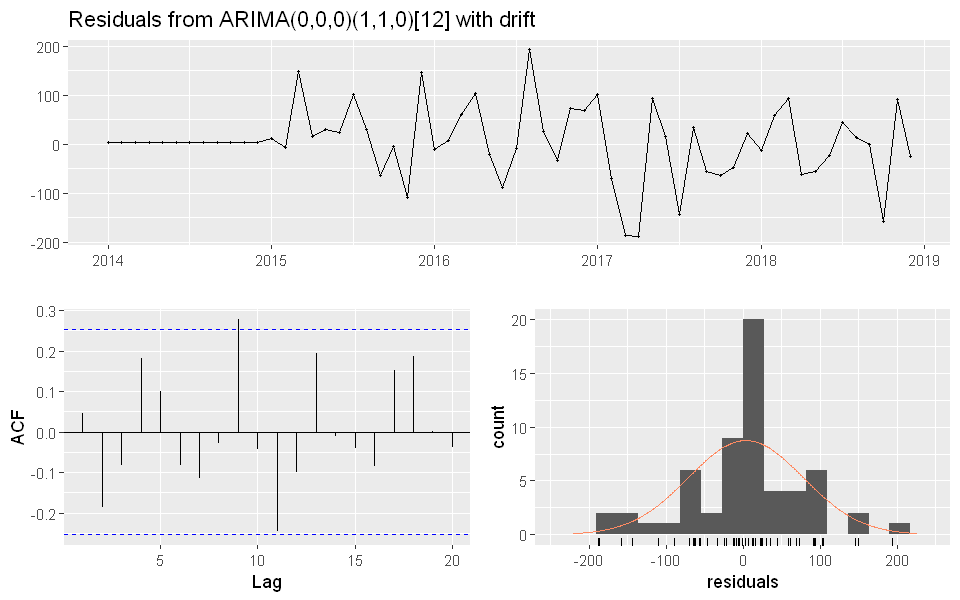

In [64]:
checkresiduals(autoarima)

CCL: Les tests valident la significativité des paramètres et la blancheur gaussienne des résidus au seuil de 1%.

In [65]:
cat('Erreur quadratique moyenne RMSE:', round(accuracy(autoarima)[, 'RMSE'], 2), '\n')
cat('Erreur absolue moyenne MAPE:', round(accuracy(autoarima)[, 'MAPE'], 2), '%')

Erreur quadratique moyenne RMSE: 73.93 
Erreur absolue moyenne MAPE: 1.76 %

CCL: Le modèle que nous avions estimé était bon et identique à celui paramétré par auto.arima, à la différence près qu'il y joint une constante en plus (bien que significativement différente de zéro).

<a href="#sommaire">Retour au sommaire</a>
## <span style='color:brown'>c) Prédiction de la consommation corrigée.<a name="M3123"></a>

On emploie donc le modèle déterminé par la auto.arima.

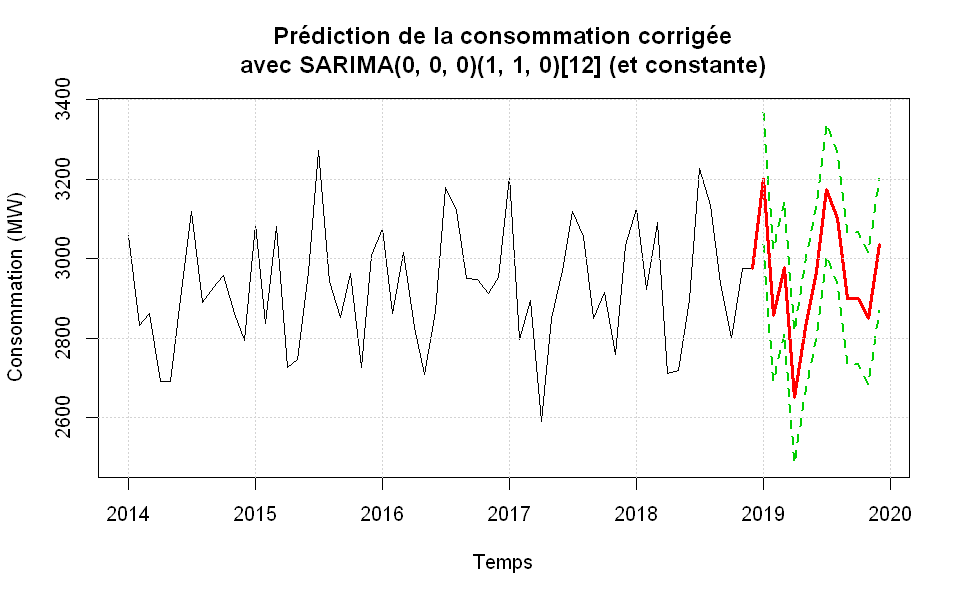

In [66]:
options(repr.plot.width = 8, repr.plot.height = 5)

pred_model = forecast(autoarima, h = 12, level = 95)

pred = ts(c(conso_corr[60], pred_model$mean), start = c(2018, 12), frequency = 12)
lower = ts(pred_model$lower, start = c(2019, 1), frequency = 12)
upper = ts(pred_model$upper, start= c(2019, 1), frequency = 12)

ts.plot(conso_corr, pred, lower, upper, xlab = 'Temps', ylab = 'Consommation (MW)', col = c(1,2,3,3), lty = c(1,1,2,2),
        lwd = c(1,3,2,2), main = 'Prédiction de la consommation corrigée\navec SARIMA(0, 0, 0)(1, 1, 0)[12] (et constante)')
grid()

In [67]:
summary(pred_model)


Forecast method: ARIMA(0,0,0)(1,1,0)[12] with drift

Model Information:
Series: conso_corr 
ARIMA(0,0,0)(1,1,0)[12] with drift 

Coefficients:
         sar1   drift
      -0.6816  1.0331
s.e.   0.1034  0.6649

sigma^2 estimated as 7129:  log likelihood=-283.75
AIC=573.51   AICc=574.06   BIC=579.12

Error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE      ACF1
Training set 3.654587 73.92973 51.45605 0.06607411 1.759434 0.5303368 0.0473015

Forecasts:
         Point Forecast    Lo 95    Hi 95
Jan 2019       3202.430 3036.943 3367.917
Feb 2019       2857.541 2692.054 3023.028
Mar 2019       2977.369 2811.882 3142.856
Apr 2019       2650.211 2484.724 2815.698
May 2019       2827.878 2662.391 2993.365
Jun 2019       2968.207 2802.720 3133.694
Jul 2019       3174.281 3008.794 3339.768
Aug 2019       3102.042 2936.555 3267.529
Sep 2019       2899.287 2733.800 3064.774
Oct 2019       2899.212 2733.725 3064.699
Nov 2019       2849.267 2683.780 3014.754
Dec 201

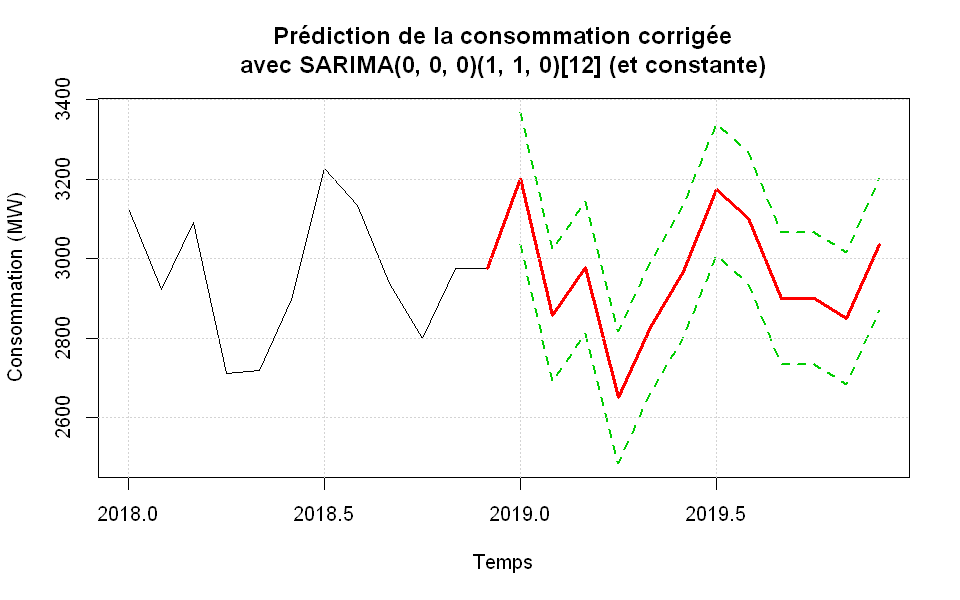

In [69]:
options(repr.plot.width = 8, repr.plot.height = 5)

pred_model = forecast(autoarima, h = 12, level = 95)

pred = ts(c(conso_corr[60], pred_model$mean), start = c(2018, 12), frequency = 12)
lower = ts(pred_model$lower, start = c(2019, 1), frequency = 12)
upper = ts(pred_model$upper, start= c(2019, 1), frequency = 12)

ts.plot(window(conso_corr, start = 2018), pred, lower, upper, xlab = 'Temps', ylab = 'Consommation (MW)', col = c(1,2,3,3), lty = c(1,1,2,2),
        lwd = c(1,3,2,2), main = 'Prédiction de la consommation corrigée\navec SARIMA(0, 0, 0)(1, 1, 0)[12] (et constante)')
grid()

<a href="#sommaire">Retour au sommaire</a>
## Analyse a posteriori:<a name="M31231"></a>

In [70]:
# On tronque la série de l’année 2018, qu’on cherche ensuite à prévoir à partir de l’historique 2014-2017.
conso_tronc = window(conso_corr, end = c(2017, 12))
conso_a_prevoir = window(conso_corr, start = c(2018, 1))

In [71]:
# On vérifie que le modèle trouvé par autoarima sur la série tronquée est toujours validé.
model_tronc <- Arima(conso_tronc, order = c(0, 0, 0), list(order = c(1, 1, 0), period = 12), include.mean = F, method = 'CSS-ML')
summary(model_tronc)

# Significativité des paramètres:
t_stat(model_tronc)

# Blancheur des résidus:
Box.test.2(model_tronc$residuals, nlag = c(6, 12, 18, 24, 30, 36), type = 'Ljung-Box', decim = 5)

# Normalité ds résidus:
shapiro.test(model_tronc$residuals)

Series: conso_tronc 
ARIMA(0,0,0)(1,1,0)[12] 

Coefficients:
         sar1
      -0.5671
s.e.   0.1535

sigma^2 estimated as 8645:  log likelihood=-216.06
AIC=436.13   AICc=436.49   BIC=439.29

Training set error measures:
                   ME    RMSE      MAE       MPE     MAPE      MASE       ACF1
Training set 17.14758 79.3973 54.91193 0.5278445 1.869558 0.6047047 0.07157157


,sar1
t.stat,-3.693358
p.val,0.000221


Retard,p-value
6,0.60340
12,0.53745
18,0.40475
24,0.62800
30,0.83148
36,0.95758



	Shapiro-Wilk normality test

data:  model_tronc$residuals
W = 0.94782, p-value = 0.03275


CCL:
- Le test du paramètre est significatif.
- Les résidus sont des bruits blancs gaussiens et sont donc stationnaires au seuil de 1%.

Au final notre modèle tronqué est viable.

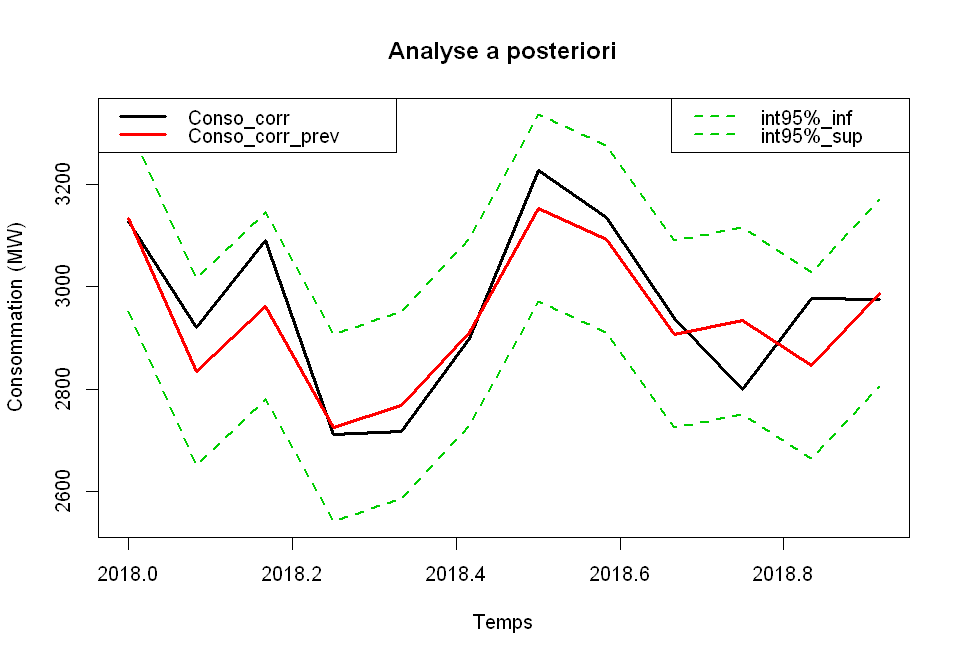

In [72]:
options(repr.plot.width = 8, repr.plot.height = 5.5)

pred_model_tronc = forecast(model_tronc, h = 12, level = 95)

pred_tronc = pred_model_tronc$mean
lower_tronc = ts(pred_model_tronc$lower, start = c(2018, 1), frequency = 12)
upper_tronc = ts(pred_model_tronc$upper, start = c(2018, 1), frequency = 12)

ts.plot(conso_a_prevoir, pred_tronc, lower_tronc, upper_tronc, xlab = 'Temps', ylab = 'Consommation (MW)',
        col = c(1, 2, 3, 3), lty = c(1, 1, 2, 2), lwd = c(3, 3, 2, 2), main = 'Analyse a posteriori')

legend('topleft', legend = c('Conso_corr', 'Conso_corr_prev'), col = c(1, 2, 3, 3), lty = c(1, 1), lwd = c(3, 3))
legend('topright', legend = c('int95%_inf', 'int95%_sup'), col = c(3, 3), lty = c(2, 2), lwd = c(2, 2))

<a href="#sommaire">Retour au sommaire</a>
# Mission 4<a name="M4"></a>
# <span style='color:red'>Prévision de la consommation initiale d'électricité sur un an.<a name="M41"></a>

On cherche donc à prédire la consommation d'électricité pour l'année 2019-2020, afin de répondre à la demande initiale.

In [73]:
model <- auto.arima(conso_ts, xreg = dju_ts, seasonal = T)
summary(model)

t_stat(model)

Box.test(resid(reg), type = 'Ljung-Box')

shapiro.test(resid(model))

Series: conso_ts 
Regression with ARIMA(0,0,0)(1,1,0)[12] errors 

Coefficients:
         sar1    xreg
      -0.6974  5.2107
s.e.   0.1052  0.2950

sigma^2 estimated as 7313:  log likelihood=-284.62
AIC=575.23   AICc=575.78   BIC=580.85

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE       ACF1
Training set 16.77531 74.87752 52.62206 0.4103491 1.472377 0.2360395 0.02905064


,sar1,xreg
t.stat,-6.630499,17.66619
p.val,0.000000,0.00000



	Box-Ljung test

data:  resid(reg)
X-squared = 1.0167, df = 1, p-value = 0.3133



	Shapiro-Wilk normality test

data:  resid(model)
W = 0.95499, p-value = 0.0269


Une régression avec des erreurs ARIMA est donnée par la formule suivante (vue sur Hyndman et al, 1998):

$Y_t=b_0+b_1X_{1,t}+ ... +b_kX_{k,t}+n_t$ où $n_t$ est modélisé comme un processus ARIMA.

CCL:
- Les paramètres sont significatifs.
- Les résidus sont des bruits blancs gaussiens et sont donc stationnaires.

Au final, notre modèle SARIMAX est viable.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


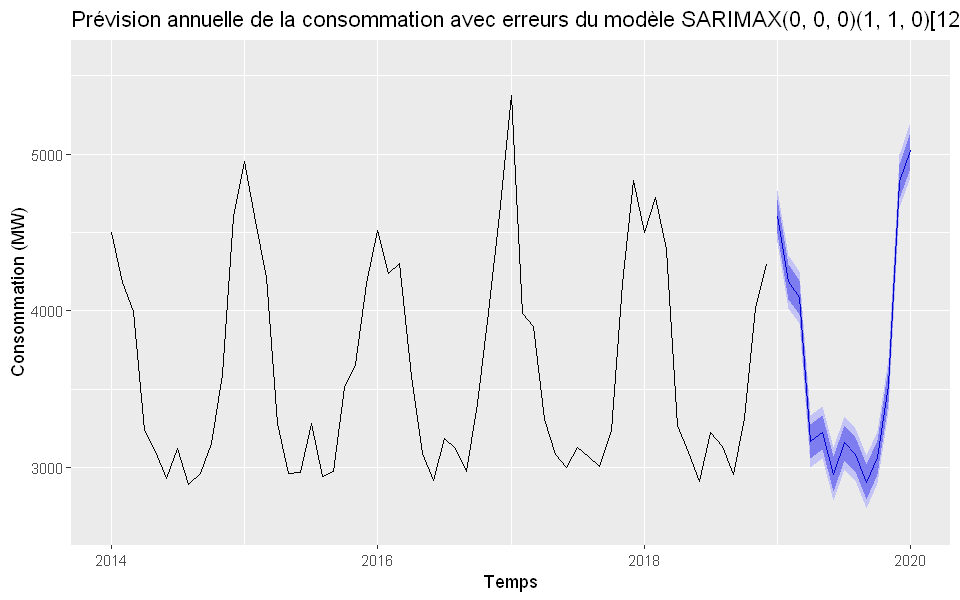

In [74]:
options(repr.plot.width = 8, repr.plot.height = 5)

prediction <- forecast(model, xreg = dju_ts, h = 12, level = c(80, 95))

autoplot(prediction, xlim = c(2014, 2020), xlab = 'Temps', ylab = 'Consommation (MW)', 
         main = 'Prévision annuelle de la consommation avec erreurs du modèle SARIMAX(0, 0, 0)(1, 1, 0)[12]')

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Warning message:
"Removed 48 row(s) containing missing values (geom_path)."

png 
  2

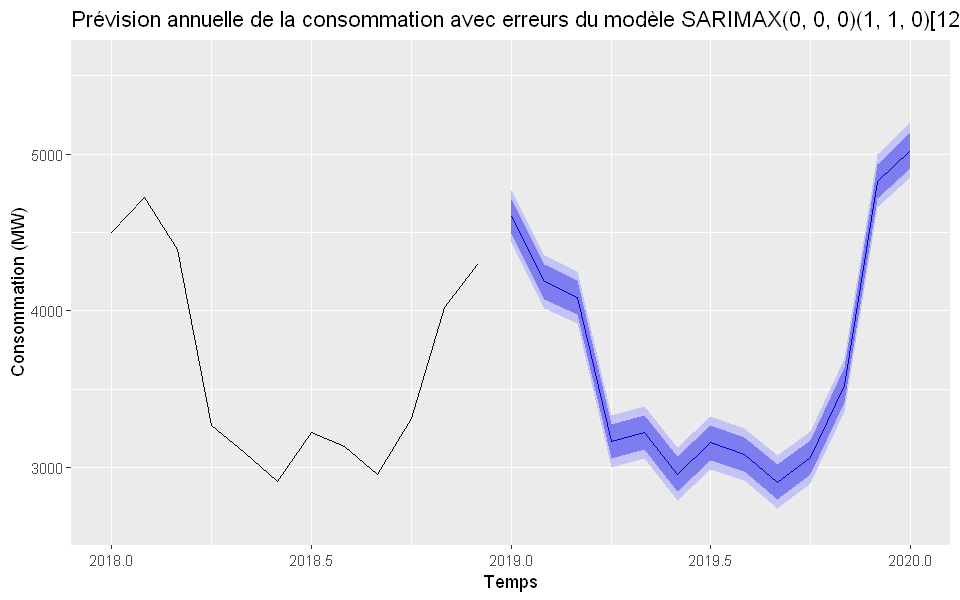

In [75]:
options(repr.plot.width = 8, repr.plot.height = 5)

prediction <- forecast(model, xreg = dju_ts, h = 12, level = c(80, 95))

autoplot(prediction, xlim = c(2018, 2020), xlab = 'Temps', ylab = 'Consommation (MW)',
         main = 'Prévision annuelle de la consommation avec erreurs du modèle SARIMAX(0, 0, 0)(1, 1, 0)[12]')

dev.print(jpeg, '28. Prévision anuelle de la consommation avec erreurs du modèle SARIMAX(0, 0, 0)(1, 1, 0)[12].jpg', 
          quality = 100, units = 'px', width = 3000, height = 1500, res = 300)

<a href="#sommaire">Retour au sommaire</a>